## Remember
Usually, the aim of K-fold cross-validation is to check how a model performs (both on average and how much it varies across folds) given some hyper-parameters setting. We then pick the "best" set of hyper-parameters.

Afterwards, we fix the hyper-parameters and train the model with full dataset to squeeze all the juice.

In the case where there is no hyper-parameters to tune e.g. simple linear regression, cross-validation can give you an estimate of how your model will perform. You then train a final model with all data.

In [182]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from pandas.core.common import flatten

pd.options.mode.chained_assignment = None  # default='warn'

In [183]:
data_path = os.path.join("..", "..", "data")

dir_store_path = os.path.join(data_path, "temporary results")

overall_dataset_path = os.path.join(dir_store_path, "overall_dataset.xlsx")

In [184]:
full_df = pd.read_excel(overall_dataset_path)

# Dataset Preprocessing

In [185]:
tntc_condition = (
    (full_df["Coliform (1ml)_mean"] == "TNTC")
    | (full_df["Ecoli (1ml)_mean"] == "TNTC")
    | (full_df["Coliform (1ml)_mean"] == 0)
)

In [186]:
tntc_df = full_df[tntc_condition]

In [187]:
clean_df = full_df.drop(tntc_df.index)

In [188]:
clean_df

Unnamed: 0            DateTime Site  Bottle  Sample  \
0             0 2023-02-07 08:18:00    D       1       0   
1             1 2023-02-07 08:18:00    D       2       0   
2             2 2023-02-14 09:55:00    D       1       0   
3             3 2023-02-14 09:55:00    D       2       0   
4             4 2023-02-21 16:10:00    D       1       0   
..          ...                 ...  ...     ...     ...   
253         253 2023-09-04 14:06:00    D       2       2   
254         254 2023-09-04 14:22:00    D       1       1   
255         255 2023-09-05 14:15:00    D       1       1   
256         256 2023-09-05 14:15:00    D       1       2   
257         257 2023-09-05 14:44:00    D       1       1   

    Technician Water Quality Technician Counting  Temp C_mean  Ph_mean  \
0                      Randa               Randa          6.0      8.1   
1                      Randa               Randa          6.0      8.2   
2                      Randa               Randa          9.0      7.8   
3                      Randa               Randa          8.0      8.0   
4                      Randa               Randa         11.0      8.0   
..                       ...                 ...          ...      ...   
253                      NaN               Admin         21.9      7.8   
254                      NaN               Admin         23.0      7.5   
255                      NaN                 Vee         23.9      7.6   
256                      NaN                 Vee         23.9      7.6   
257                      NaN                 Vee         23.0      7.7   

     Cond (ms)_mean Coliform (1ml)_mean Ecoli (1ml)_mean  cso_active  \
0              0.80                  16                6       False   
1              0.77                  10                6       False   
2              0.80                  11                5       False   
3              0.80                  22                7       False   
4              1.25                  19                6       False   
..              ...                 ...              ...         ...   
253            1.46                35.5              3.5       False   
254            1.49                67.5                8       False   
255            1.46                34.5                8       False   
256            1.46                36.5              8.5       False   
257            1.44                  54              6.5       False   

     Deptford_rainfall_6h  Holland Park_rainfall_6h  Putney Heath_rainfall_6h  \
0                     0.0                       0.0                       0.0   
1                     0.0                       0.0                       0.0   
2                     0.0                       0.0                       0.0   
3                     0.0                       0.0                       0.0   
4                     0.0                       0.0                       0.0   
..                    ...                       ...                       ...   
253                   0.0                       0.0                       0.0   
254                   0.0                       0.0                       0.0   
255                   0.0                       0.0                       0.0   
256                   0.0                       0.0                       0.0   
257                   0.0                       0.0                       0.0   

     Hogsmill Valley_rainfall_6h TideType  
0                            0.0     high  
1                            0.0     high  
2                            0.0   normal  
3                            0.0   normal  
4                            0.0     high  
..                           ...      ...  
253                          0.0   normal  
254                          0.0     high  
255                          0.0   normal  
256                          0.0   normal  
257                          0.0     high  

[257 rows x 18 columns]

In [189]:
clean_df.drop(columns=["Unnamed: 0"], inplace=True)

In [190]:
clean_df.reset_index(drop=True, inplace=True)

# Utils

In [191]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut

In [192]:
import sklearn.metrics as metrics


def regression_results(y_true, y_pred):
    # Regression metrics
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))

# Per Site Ecoli Regression

In [193]:
ecoli_df = clean_df.drop(columns=["Coliform (1ml)_mean"])

In [194]:
# TAKE ONLY AUTOMATIC COUNTING DATA
ecoli_df = ecoli_df[ecoli_df["DateTime"] > "2023-07-01"]

ecoli_df.reset_index(drop=True, inplace=True)

### Perform One-Hot Encoding on categorical features

In [195]:
from sklearn.preprocessing import OneHotEncoder

In [196]:
categorical_columns = ["TideType", "cso_active"]

for column in categorical_columns:
    enc = OneHotEncoder(handle_unknown="ignore")
    enc_df = pd.DataFrame(enc.fit_transform(ecoli_df[[column]]).toarray())
    enc_df.columns = enc.get_feature_names_out([column])
    ecoli_df = pd.concat([ecoli_df, enc_df], axis=1)
    ecoli_df.drop(columns=[column], inplace=True)

In [197]:
ecoli_df

DateTime Site  Bottle  Sample Technician Water Quality  \
0   2023-07-31 14:00:00    C       1       1            Anan - Alisha   
1   2023-07-31 14:00:00    C       1       2            Anan - Alisha   
2   2023-07-31 14:00:00    C       2       1            Anan - Alisha   
3   2023-07-31 14:00:00    C       2       2            Anan - Alisha   
4   2023-08-01 15:20:00    C       1       1            Anan - Alisha   
..                  ...  ...     ...     ...                      ...   
231 2023-09-04 14:06:00    D       2       2                      NaN   
232 2023-09-04 14:22:00    D       1       1                      NaN   
233 2023-09-05 14:15:00    D       1       1                      NaN   
234 2023-09-05 14:15:00    D       1       2                      NaN   
235 2023-09-05 14:44:00    D       1       1                      NaN   

    Technician Counting  Temp C_mean  Ph_mean  Cond (ms)_mean  \
0                 Randa         20.0      7.8        1.930000   
1                 Randa         20.0      7.8        1.930000   
2                 Randa         20.0      7.8        1.950000   
3                 Randa         20.0      7.8        1.950000   
4                 Randa         21.0      7.8        1.765625   
..                  ...          ...      ...             ...   
231               Admin         21.9      7.8        1.460000   
232               Admin         23.0      7.5        1.490000   
233                 Vee         23.9      7.6        1.460000   
234                 Vee         23.9      7.6        1.460000   
235                 Vee         23.0      7.7        1.440000   

    Ecoli (1ml)_mean  Deptford_rainfall_6h  Holland Park_rainfall_6h  \
0              24.25                   0.8                       1.0   
1              33.25                   0.8                       1.0   
2                 22                   0.8                       1.0   
3              24.25                   0.8                       1.0   
4          40.666667                   0.0                       0.0   
..               ...                   ...                       ...   
231              3.5                   0.0                       0.0   
232                8                   0.0                       0.0   
233                8                   0.0                       0.0   
234              8.5                   0.0                       0.0   
235              6.5                   0.0                       0.0   

     Putney Heath_rainfall_6h  Hogsmill Valley_rainfall_6h  TideType_high  \
0                         1.4                          1.3            1.0   
1                         1.4                          1.3            1.0   
2                         1.4                          1.3            1.0   
3                         1.4                          1.3            1.0   
4                         0.0                          0.0            1.0   
..                        ...                          ...            ...   
231                       0.0                          0.0            0.0   
232                       0.0                          0.0            1.0   
233                       0.0                          0.0            0.0   
234                       0.0                          0.0            0.0   
235                       0.0                          0.0            1.0   

     TideType_low  TideType_normal  cso_active_False  
0             0.0              0.0               1.0  
1             0.0              0.0               1.0  
2             0.0              0.0               1.0  
3             0.0              0.0               1.0  
4             0.0              0.0               1.0  
..            ...              ...               ...  
231           0.0              1.0               1.0  
232           0.0              0.0               1.0  
233           0.0              1.0               1.0  
234           0.0

## One-at-a-time Relationship

### Temperature

In [198]:
temp_results = {}

In [77]:
X, y = ecoli_df[["Site", "Temp C_mean"]], ecoli_df[["Site", "Ecoli (1ml)_mean"]]

#### Linear Regression

In [78]:
temp_results["LinearRegression"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)
        # evaluate model
        yhat = lin_reg.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0][0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    temp_results["LinearRegression"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

#### Ridge Regression

In [79]:
temp_results["Ridge"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        ridge = Ridge()
        ridge.fit(X_train, y_train)
        # evaluate model
        yhat = ridge.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0][0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    temp_results["Ridge"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

#### Lasso Regression

In [80]:
temp_results["Lasso"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        lasso = Lasso()
        lasso.fit(X_train, y_train)
        # evaluate model
        yhat = lasso.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    temp_results["Lasso"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

#### Bayesian Linear Regression

In [81]:
temp_results["BayesianLinearRegression"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        bayeasian_ridge = BayesianRidge()
        bayeasian_ridge.fit(X_train, y_train)
        # evaluate model
        yhat = bayeasian_ridge.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    temp_results["BayesianLinearRegression"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=T

#### Polynomial Regression

In [82]:
temp_results["PolynomialRegression"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(X_site)
    poly_features = pd.DataFrame(poly_features)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(poly_features):
        # split data
        X_train, X_test = (
            poly_features.iloc[train_ix, :],
            poly_features.iloc[test_ix, :],
        )
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)
        # evaluate model
        yhat = lin_reg.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0][0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    temp_results["PolynomialRegression"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

#### Temperature Results

In [83]:
rows = []

for model in temp_results.keys():
    for site in temp_results[model].keys():
        row = {
            "Model": model,
            "Site": site,
            "MSE": temp_results[model][site]["mse"],
            "RMSE": temp_results[model][site]["rmse"],
            "R2": temp_results[model][site]["r2"],
            "Residuals": temp_results[model][site]["residuals"],
            "y_pred": temp_results[model][site]["y_pred"],
            "y_true": temp_results[model][site]["y_true"],
        }
        rows.append(row)

df_results = pd.DataFrame(rows)
df_results.sort_values(by=["Site"], inplace=True)

In [84]:
for site in df_results["Site"].unique():
    print(f"====================== Site: {site} ======================")
    for model in df_results["Model"].unique():
        print("MODEL:", model)
        y_test = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_true"].values[0]
        y_pred = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_pred"].values[0]
        regression_results(y_test, y_pred)
        print()

====================== Site: A ======================
MODEL: PolynomialRegression
r2:  0.1658
MAE:  6.1268
MSE:  89.7953
RMSE:  9.476

MODEL: BayesianLinearRegression
r2:  0.056
MAE:  6.85
MSE:  101.6091
RMSE:  10.0801

MODEL: LinearRegression
r2:  0.0658
MAE:  6.9703
MSE:  100.5628
RMSE:  10.0281

MODEL: Lasso
r2:  0.0477
MAE:  6.7499
MSE:  102.5084
RMSE:  10.1246

MODEL: Ridge
r2:  0.0676
MAE:  6.9198
MSE:  100.3641
RMSE:  10.0182

====================== Site: B ======================
MODEL: PolynomialRegression
r2:  -0.0014
MAE:  8.0193
MSE:  105.2677
RMSE:  10.26

MODEL: BayesianLinearRegression
r2:  -0.049
MAE:  8.4932
MSE:  110.2663
RMSE:  10.5008

MODEL: LinearRegression
r2:  -0.0585
MAE:  8.5916
MSE:  111.2606
RMSE:  10.548

MODEL: Lasso
r2:  -0.0512
MAE:  8.525
MSE:  110.4985
RMSE:  10.5118

MODEL: Ridge
r2:  -0.0582
MAE:  8.5902
MSE:  111.2365
RMSE:  10.5469

====================== Site: C ======================
MODEL: PolynomialRegression
r2:  -0.014
MAE:  22.6019
MSE:  1126

##### Estimated Functions

In [85]:
%%script false --no-raise-error

# plot each estimated function and the real data points for each site
for site in df_results["Site"].unique():
    for model in df_results["Model"].unique():

        if model == "PolynomialRegression":
            result_model_site = df_results[
                (df_results["Site"] == site) & (df_results["Model"] == model)
            ]

            coefficients = result_model_site["Coefficients"].values[0]
            intercept = result_model_site["Intercept"].values[0]

            x_est = np.linspace(0, 30, 100)
            y_est = intercept + coefficients[0] * x_est + coefficients[1] * x_est ** 2

            plt.plot(x_est, y_est, label=model)
            plt.scatter(X[X["Site"] == site]["Temp C_mean"], y[y['Site'] == site]['Ecoli (1ml)_mean'], label="Real Data")
            plt.title(f"Site: {site} - {model}")
        else:
            result_model_site = df_results[
                (df_results["Site"] == site) & (df_results["Model"] == model)
            ]

            coefficients = result_model_site["Coefficients"].values[0]
            intercept = result_model_site["Intercept"].values[0]

            x_est = np.linspace(0, 30, 100)
            y_est = intercept + coefficients[0] * x_est

            plt.plot(x_est, y_est, label=model)
            plt.scatter(X[X["Site"] == site]["Temp C_mean"], y[y['Site'] == site]['Ecoli (1ml)_mean'], label="Real Data")
            plt.title(f"Site: {site} - {model}")
        plt.show()
        print()

##### Residuals

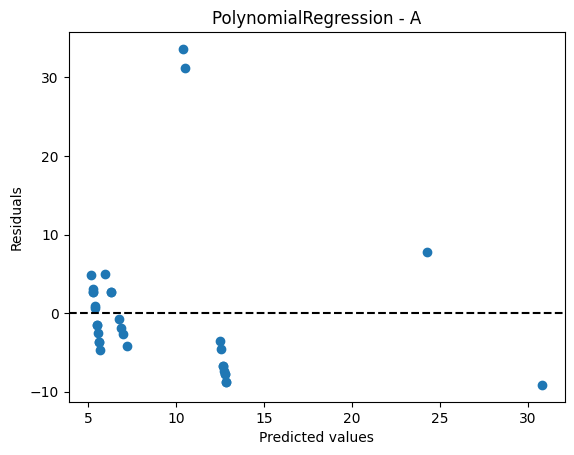

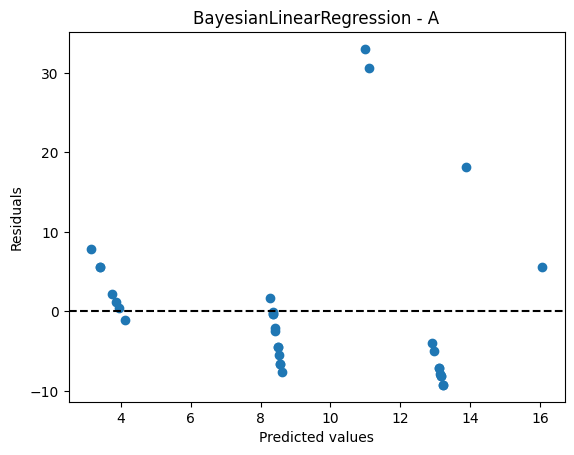

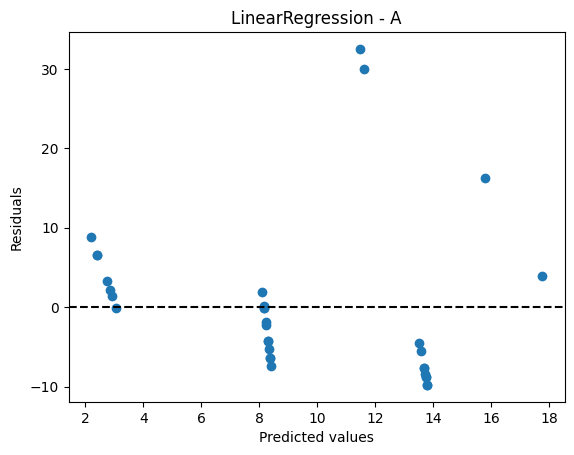

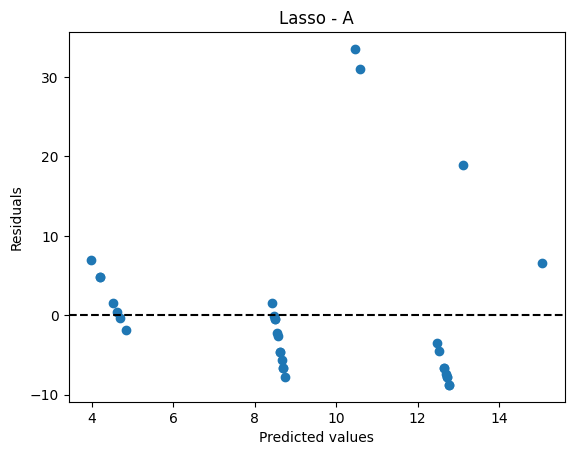

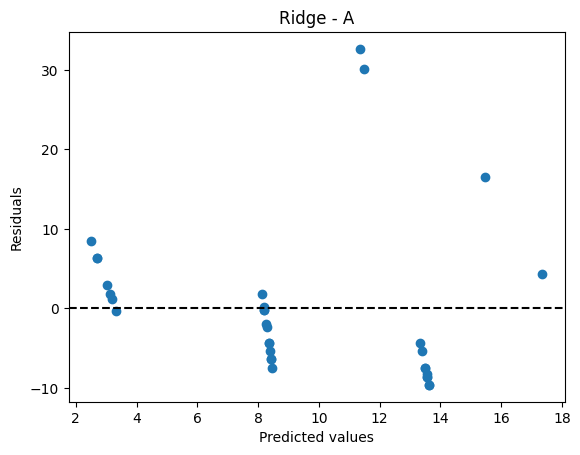

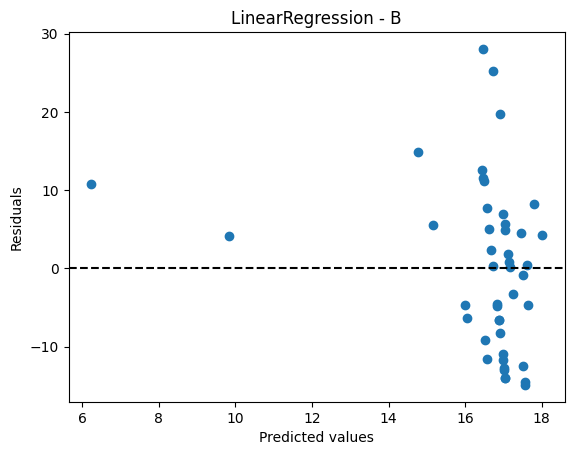

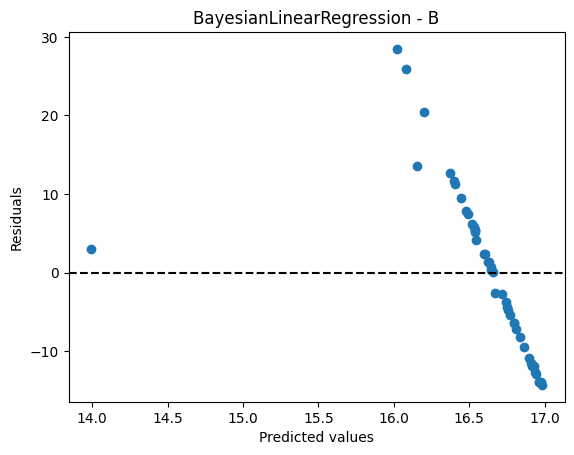

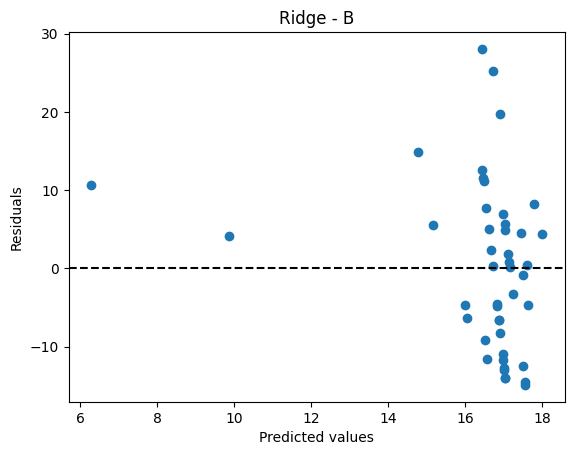

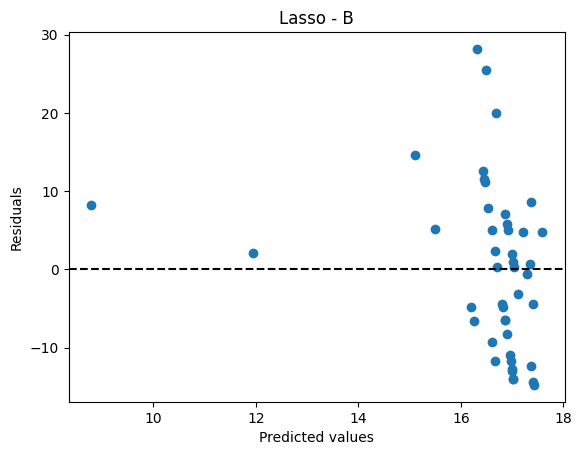

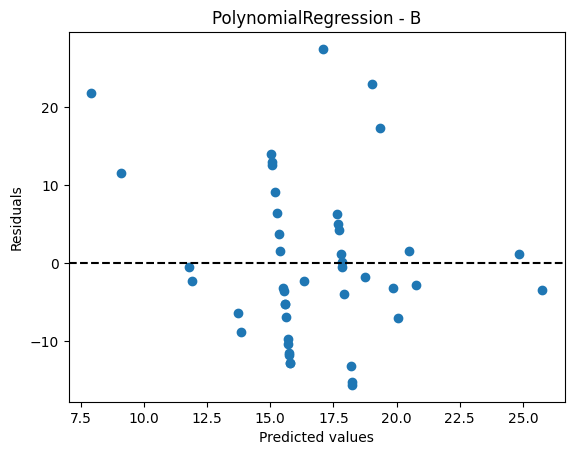

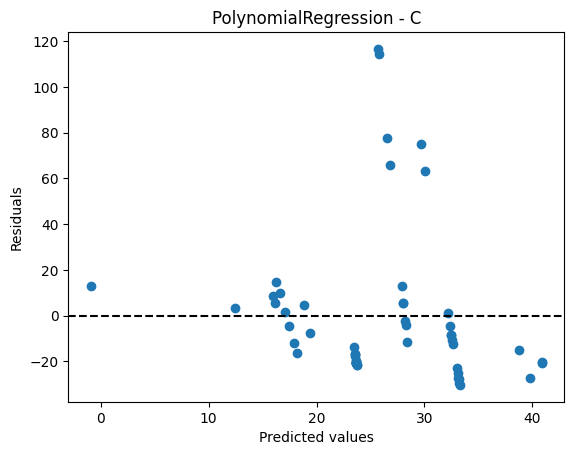

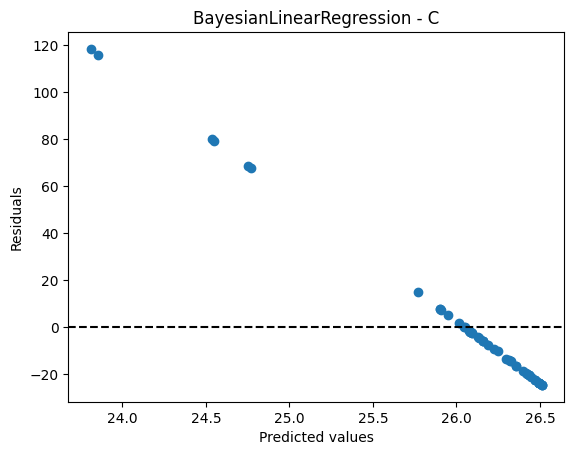

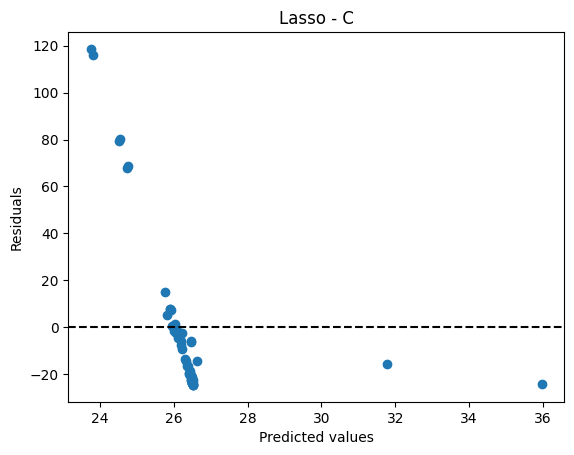

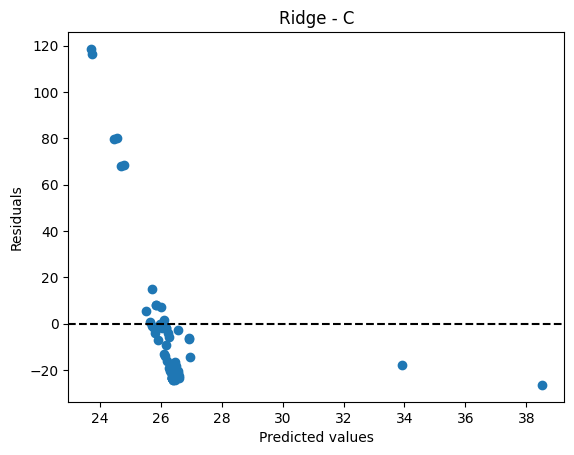

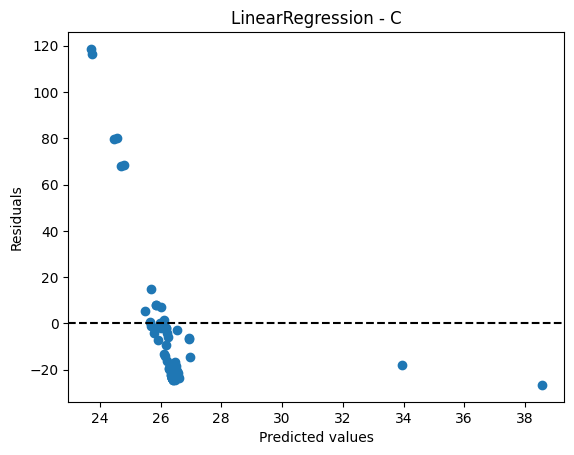

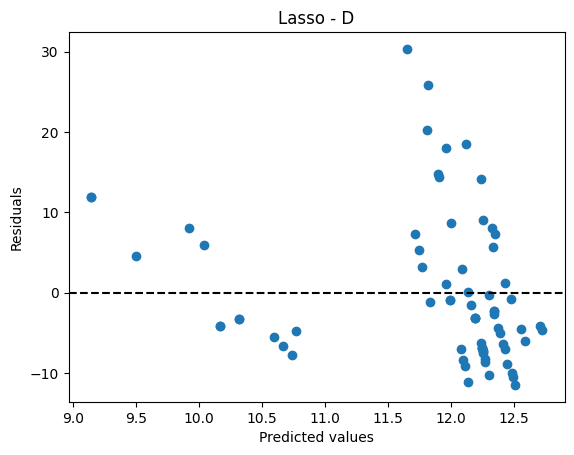

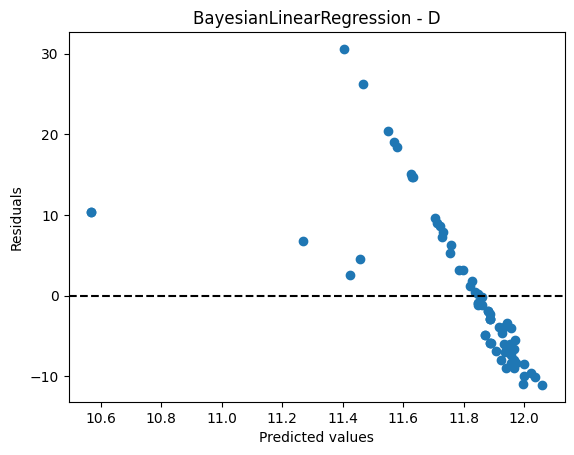

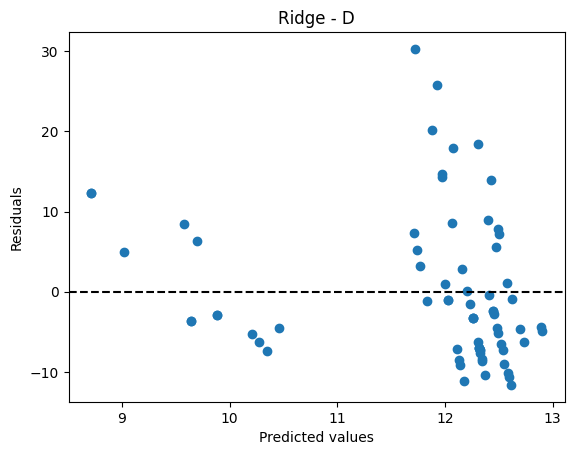

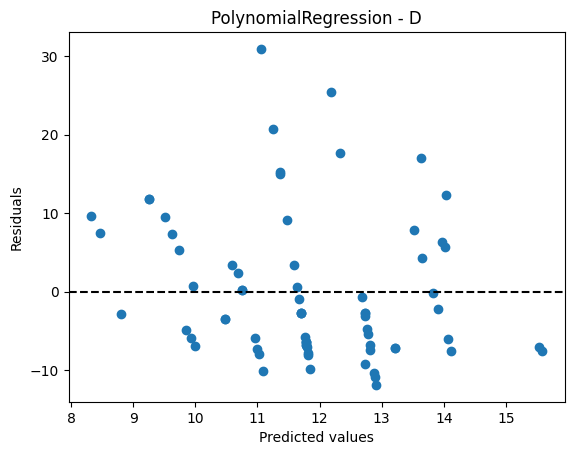

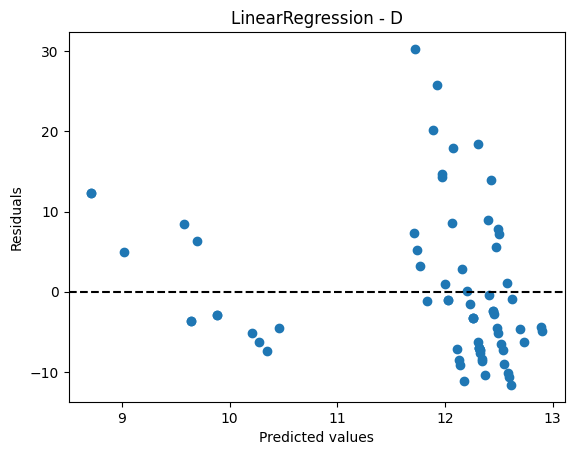

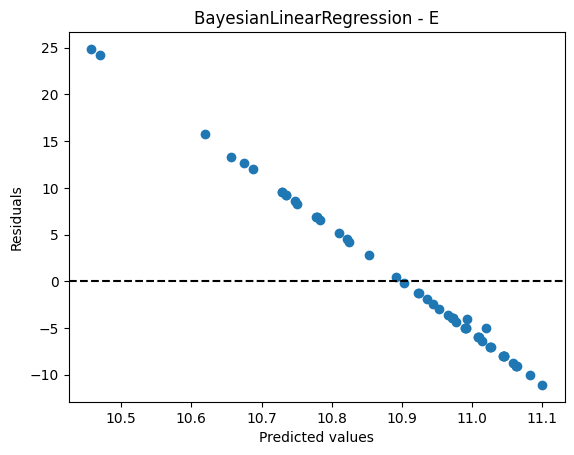

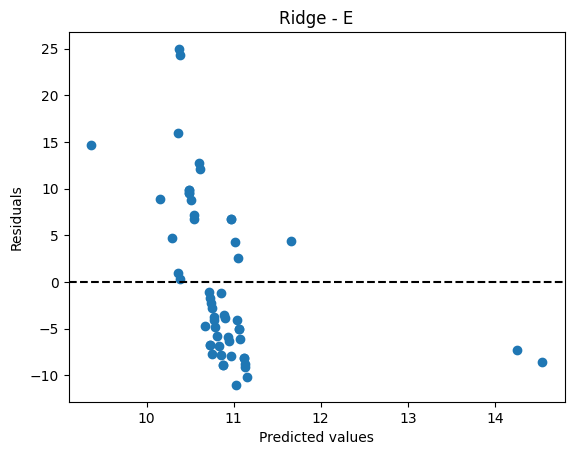

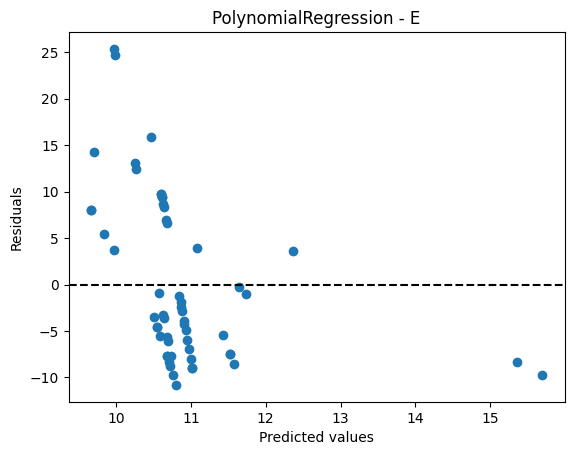

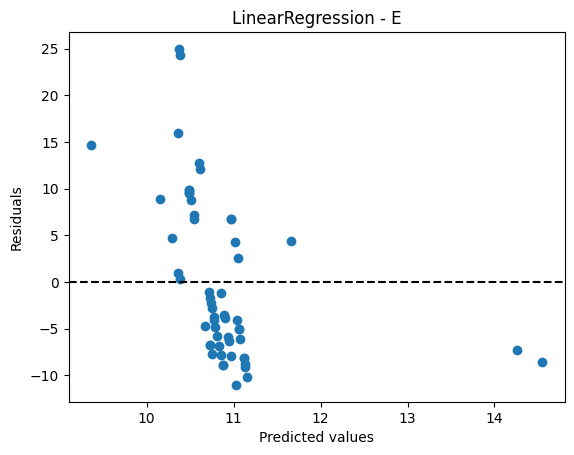

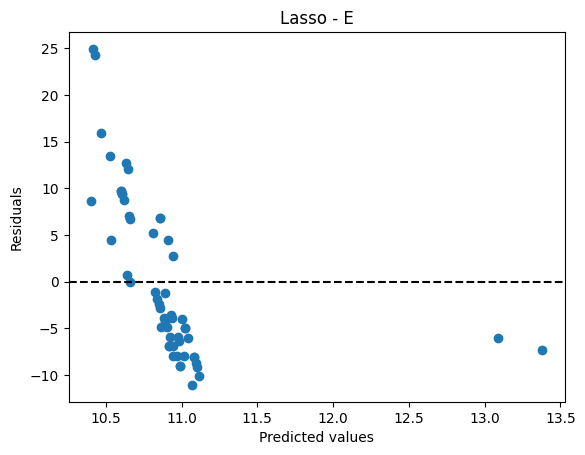

In [86]:
for site in df_results["Site"].unique():
    df_site = df_results[df_results["Site"] == site]
    for model in df_site["Model"].unique():
        df_model = df_site[df_site["Model"] == model]
        y_pred = df_model["y_pred"].values[0]
        residuals = df_model["Residuals"].values[0]
        plt.scatter(y_pred, residuals)
        plt.axhline(y=0.0, color="black", linestyle="--")
        plt.title(f"{model} - {site}")
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.show()

##### Predicted vs Actual

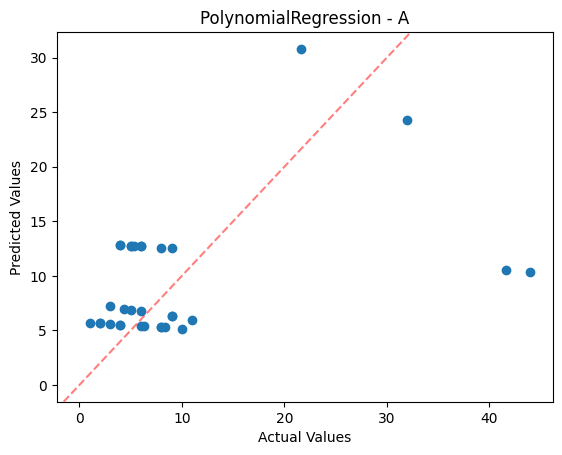

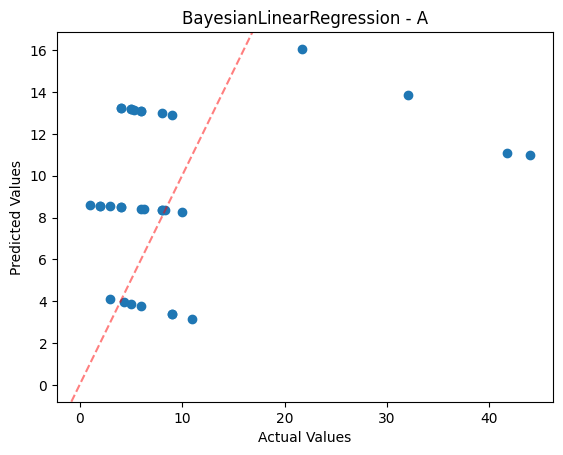

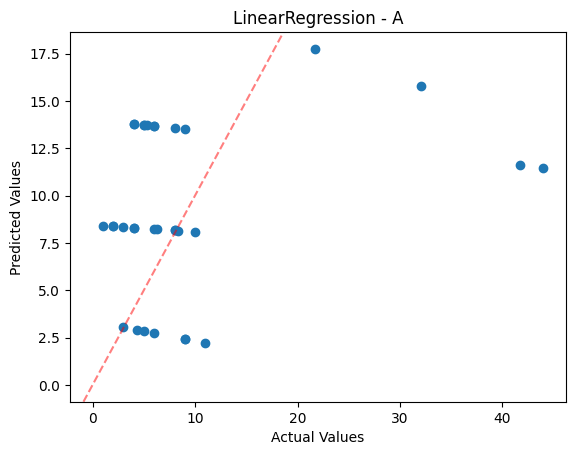

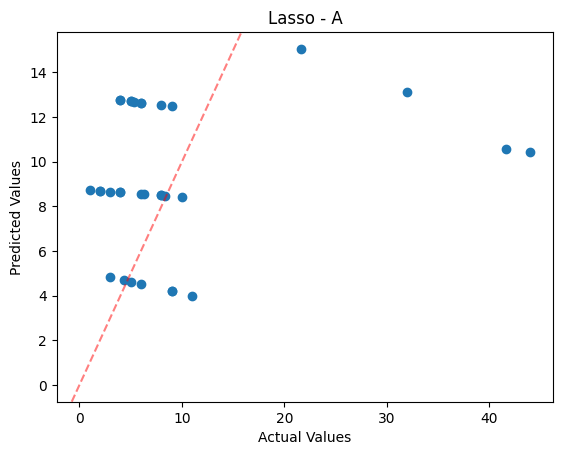

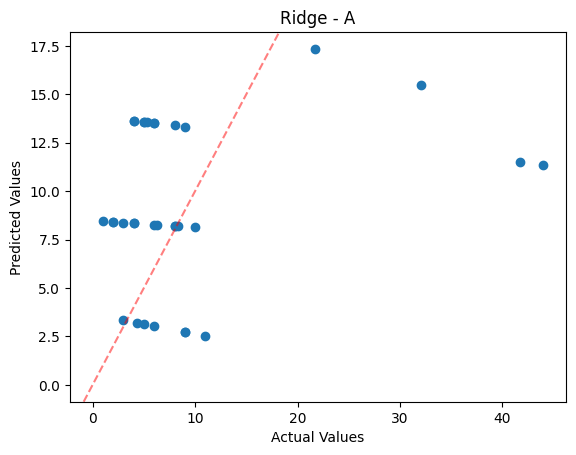

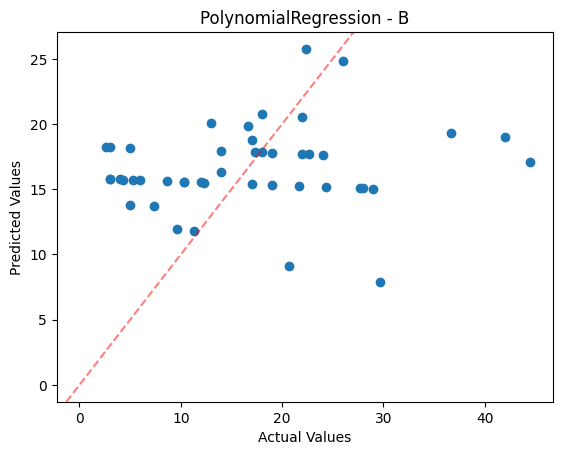

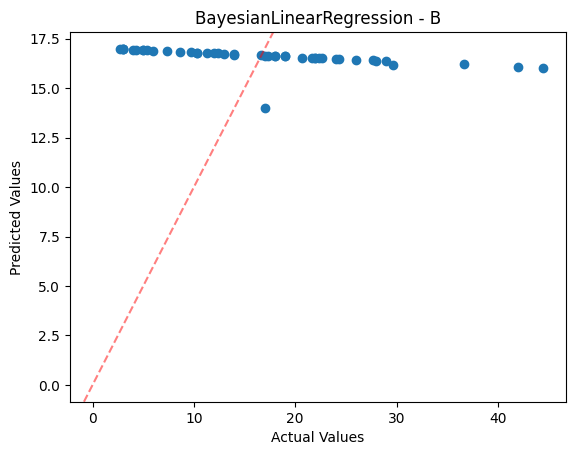

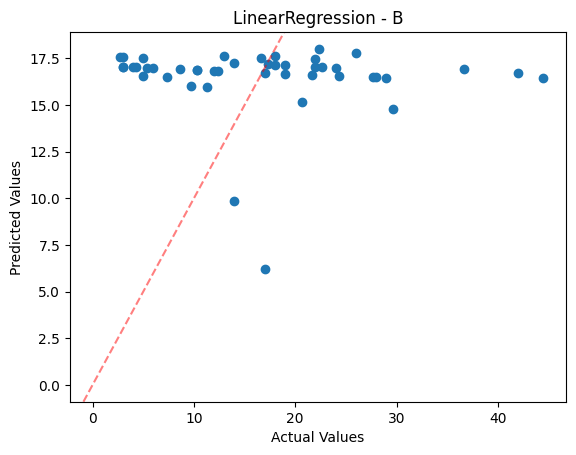

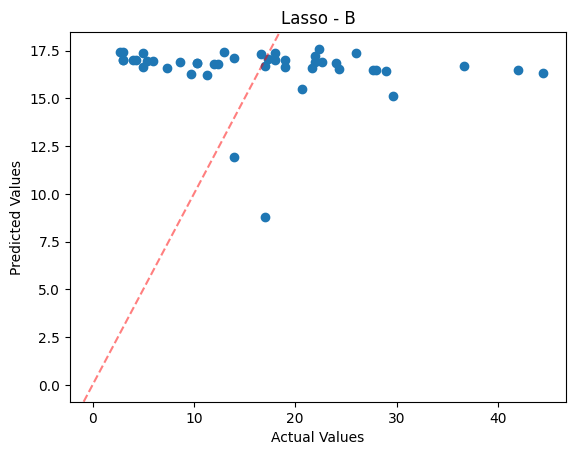

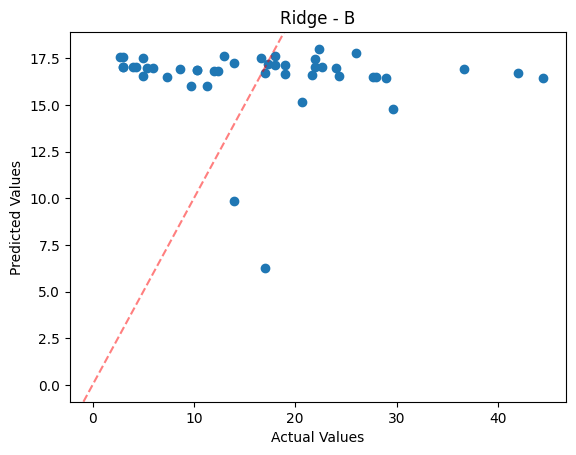

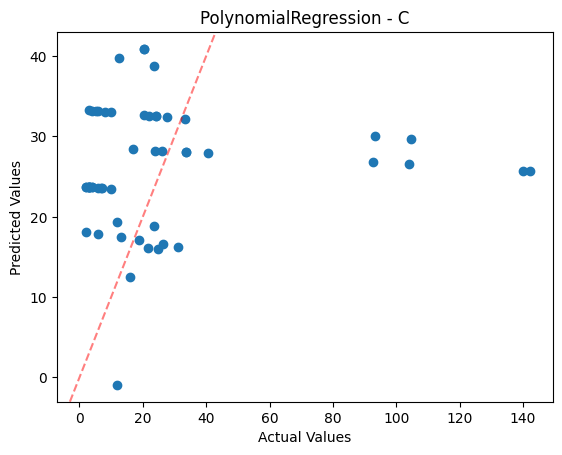

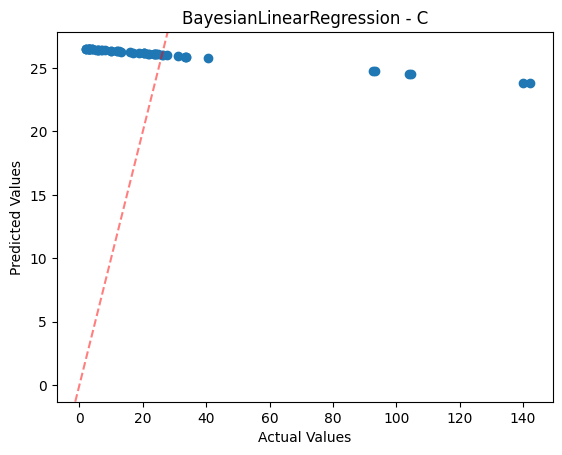

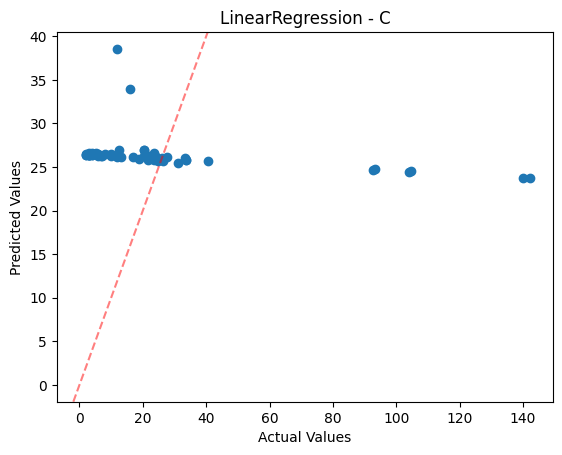

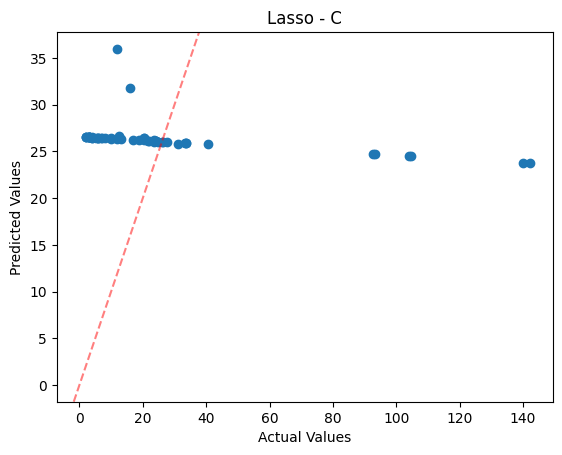

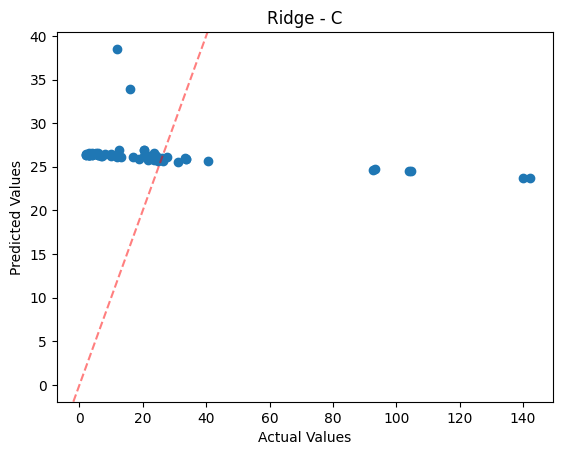

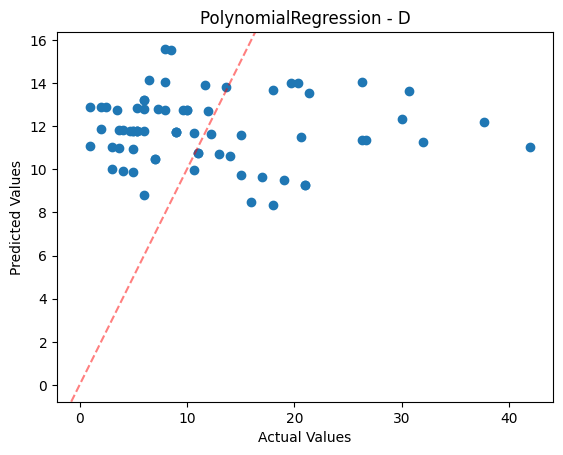

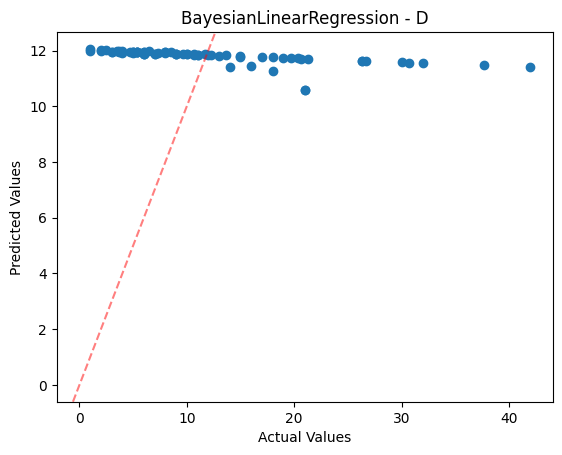

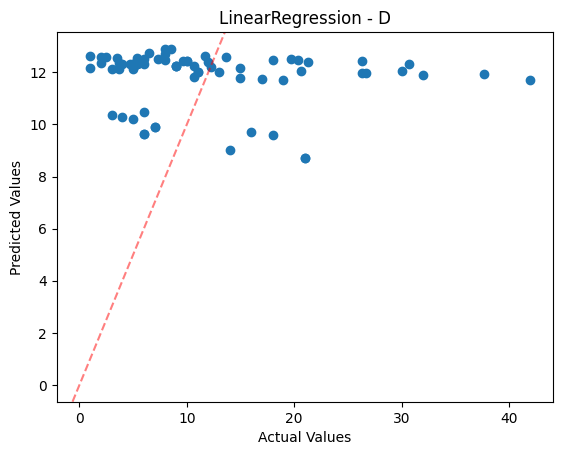

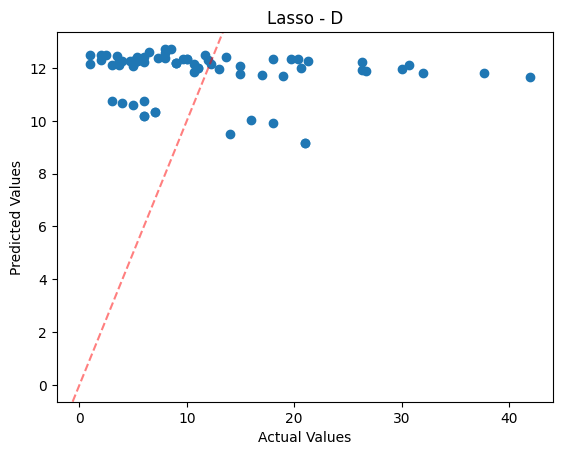

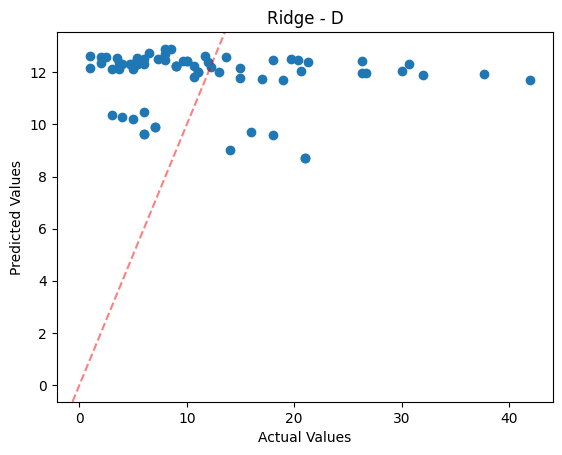

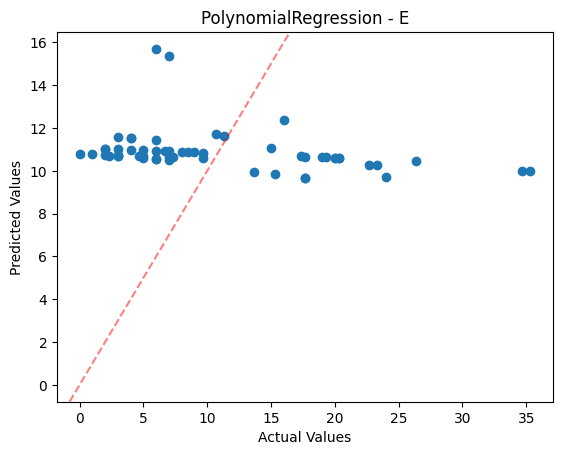

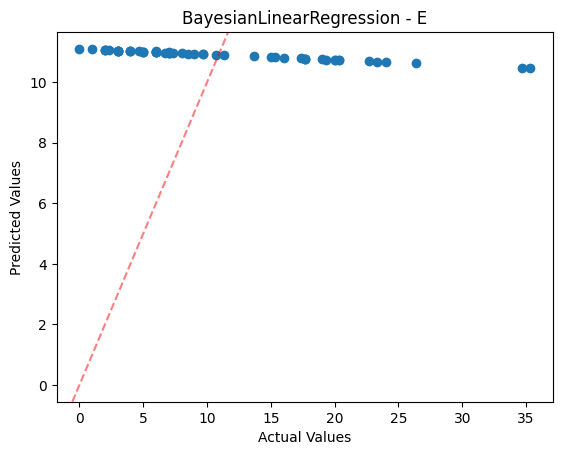

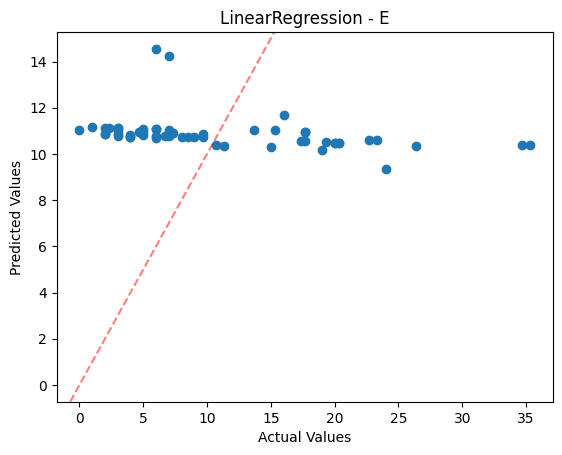

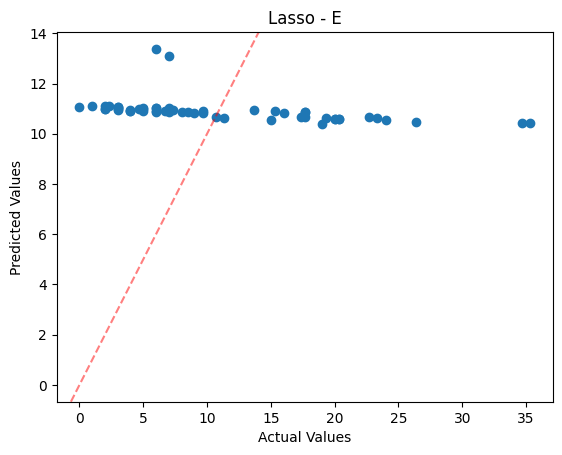

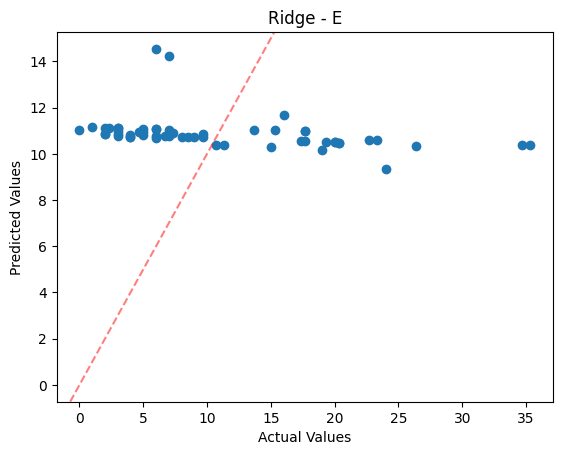

In [87]:
for site in df_results["Site"].unique():
    for model in df_results["Model"].unique():
        y_test = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_true"].values[0]
        y_pred = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_pred"].values[0]

        plt.scatter(y_test, y_pred)
        plt.axline([0, 0], [1, 1], color="red", linestyle="--", alpha=0.5)
        plt.title(f"{model} - {site}")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.show()

### pH

In [88]:
ph_results = {}

In [89]:
X, y = ecoli_df[["Site", "Ph_mean"]], ecoli_df[["Site", "Ecoli (1ml)_mean"]]

#### Linear Regression

In [90]:
ph_results["LinearRegression"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)
        # evaluate model
        yhat = lin_reg.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0][0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    ph_results["LinearRegression"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

#### Ridge Regression

In [91]:
ph_results["Ridge"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        ridge = Ridge()
        ridge.fit(X_train, y_train)
        # evaluate model
        yhat = ridge.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0][0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    ph_results["Ridge"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

#### Lasso Regression

In [92]:
ph_results["Lasso"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        lasso = Lasso()
        lasso.fit(X_train, y_train)
        # evaluate model
        yhat = lasso.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    ph_results["Lasso"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

#### Bayesian Linear Regression

In [93]:
ph_results["BayesianLinearRegression"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        bayeasian_ridge = BayesianRidge()
        bayeasian_ridge.fit(X_train, y_train)
        # evaluate model
        yhat = bayeasian_ridge.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    ph_results["BayesianLinearRegression"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=T

#### Polynomial Regression

In [94]:
ph_results["PolynomialRegression"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(X_site)
    poly_features = pd.DataFrame(poly_features)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(poly_features):
        # split data
        X_train, X_test = (
            poly_features.iloc[train_ix, :],
            poly_features.iloc[test_ix, :],
        )
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)
        # evaluate model
        yhat = lin_reg.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0][0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    ph_results["PolynomialRegression"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

#### pH Results

In [95]:
rows = []

for model in ph_results.keys():
    for site in ph_results[model].keys():
        row = {
            "Model": model,
            "Site": site,
            "MSE": ph_results[model][site]["mse"],
            "R2": ph_results[model][site]["r2"],
            "Residuals": ph_results[model][site]["residuals"],
            "y_pred": ph_results[model][site]["y_pred"],
            "y_true": ph_results[model][site]["y_true"],
        }
        rows.append(row)

df_results = pd.DataFrame(rows)
df_results.sort_values(by=["Site"], inplace=True)

In [96]:
for site in df_results["Site"].unique():
    print(f"====================== Site: {site} ======================")
    for model in df_results["Model"].unique():
        print("MODEL:", model)
        y_test = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_true"].values[0]
        y_pred = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_pred"].values[0]
        regression_results(y_test, y_pred)
        print()

====================== Site: A ======================
MODEL: PolynomialRegression
r2:  0.8119
MAE:  3.4567
MSE:  20.245
RMSE:  4.4994

MODEL: BayesianLinearRegression
r2:  0.478
MAE:  6.1611
MSE:  56.1862
RMSE:  7.4957

MODEL: LinearRegression
r2:  0.4844
MAE:  6.1549
MSE:  55.4969
RMSE:  7.4496

MODEL: Lasso
r2:  -0.0498
MAE:  6.5053
MSE:  113.0013
RMSE:  10.6302

MODEL: Ridge
r2:  0.2349
MAE:  5.8309
MSE:  82.3558
RMSE:  9.075

====================== Site: B ======================
MODEL: PolynomialRegression
r2:  -0.1307
MAE:  8.91
MSE:  118.8528
RMSE:  10.902

MODEL: BayesianLinearRegression
r2:  -0.046
MAE:  8.4308
MSE:  109.9483
RMSE:  10.4856

MODEL: LinearRegression
r2:  -0.0881
MAE:  8.67
MSE:  114.3797
RMSE:  10.6948

MODEL: Lasso
r2:  -0.046
MAE:  8.4308
MSE:  109.9477
RMSE:  10.4856

MODEL: Ridge
r2:  -0.06
MAE:  8.5061
MSE:  111.4244
RMSE:  10.5558

====================== Site: C ======================
MODEL: PolynomialRegression
r2:  0.3173
MAE:  19.1614
MSE:  758.4271
RMS

##### Estimated Functions

In [98]:
%%script false --no-raise-error

# plot each estimated function and the real data points for each site
for site in df_results["Site"].unique():
    for model in df_results["Model"].unique():

        if model == "PolynomialRegression":
            result_model_site = df_results[
                (df_results["Site"] == site) & (df_results["Model"] == model)
            ]

            coefficients = result_model_site["Coefficients"].values[0]
            intercept = result_model_site["Intercept"].values[0]

            x_est = np.linspace(0, 10, 100)
            y_est = intercept + coefficients[0] * x_est + coefficients[1] * x_est ** 2

            plt.plot(x_est, y_est, label=model)
            plt.scatter(X[X["Site"] == site]["Ph_mean"], y[y['Site'] == site]['Ecoli (1ml)_mean'], label="Real Data")
            plt.title(f"Site: {site} - {model}")
        else:
            result_model_site = df_results[
                (df_results["Site"] == site) & (df_results["Model"] == model)
            ]

            coefficients = result_model_site["Coefficients"].values[0]
            intercept = result_model_site["Intercept"].values[0]

            x_est = np.linspace(0, 10, 100)
            y_est = intercept + coefficients[0] * x_est

            plt.plot(x_est, y_est, label=model)
            plt.scatter(X[X["Site"] == site]["Ph_mean"], y[y['Site'] == site]['Ecoli (1ml)_mean'], label="Real Data")
            plt.title(f"Site: {site} - {model}")
        plt.show()
        print()

##### Residuals

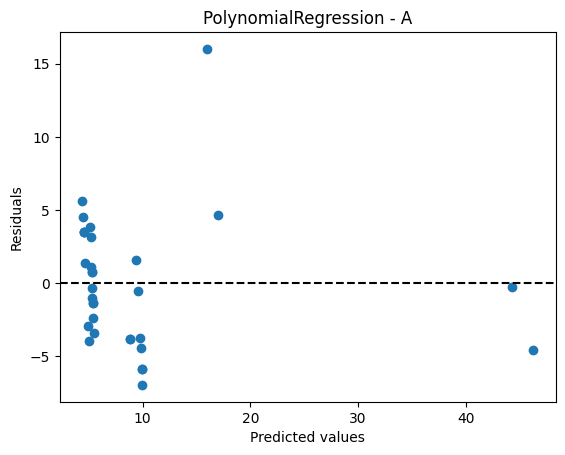

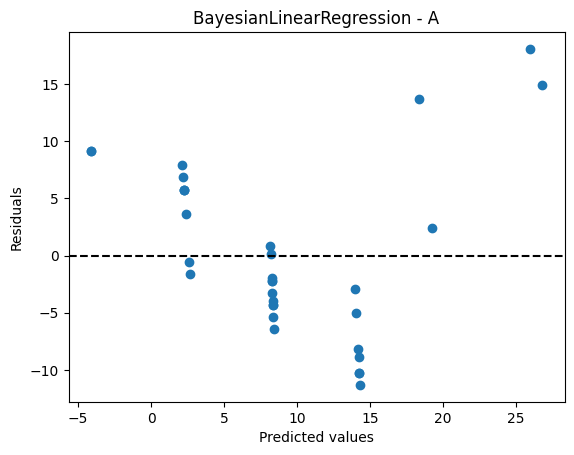

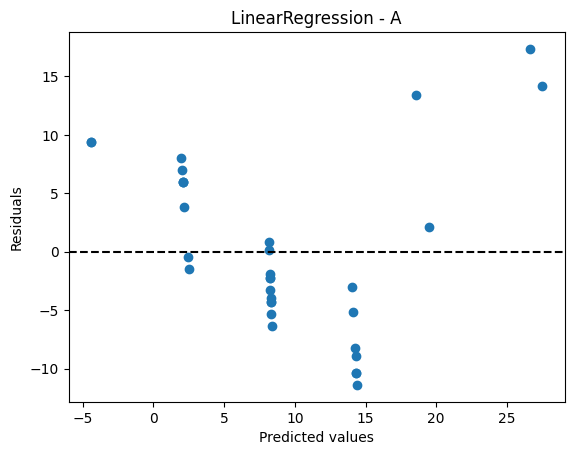

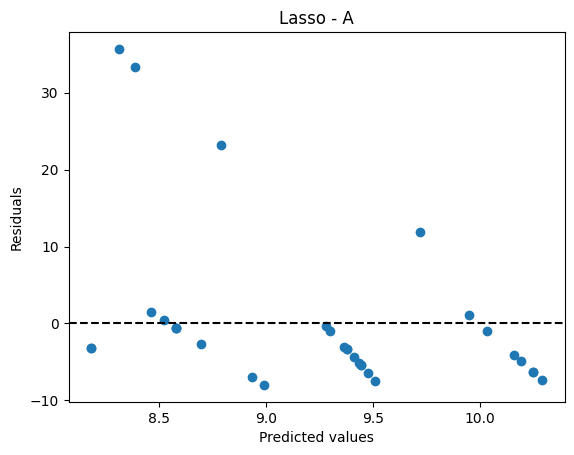

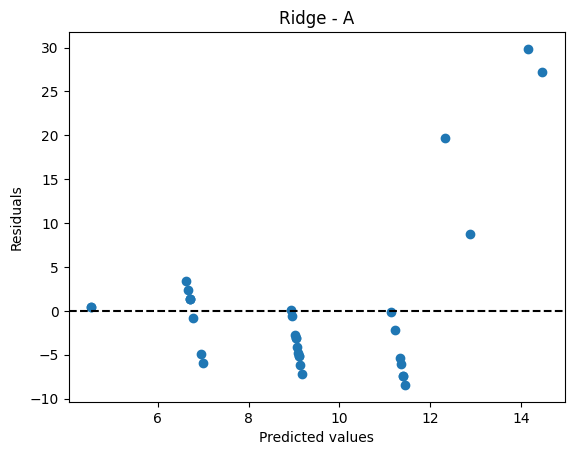

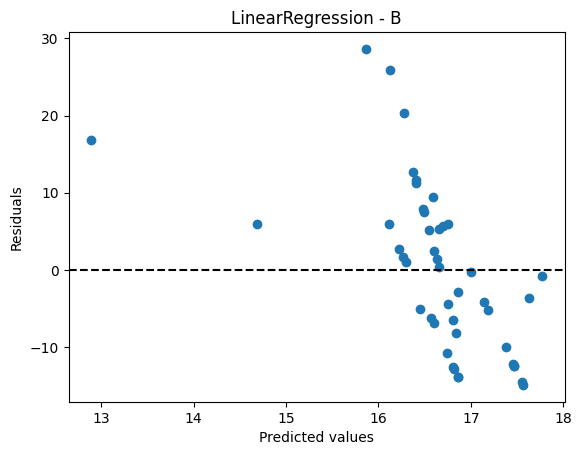

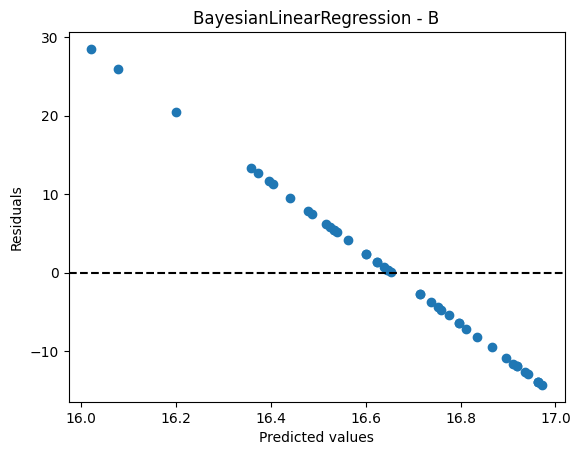

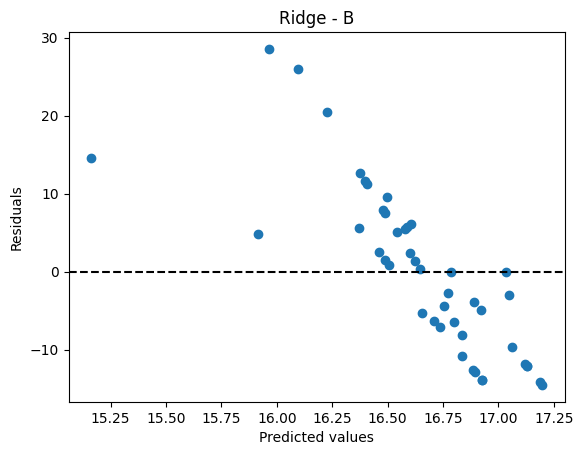

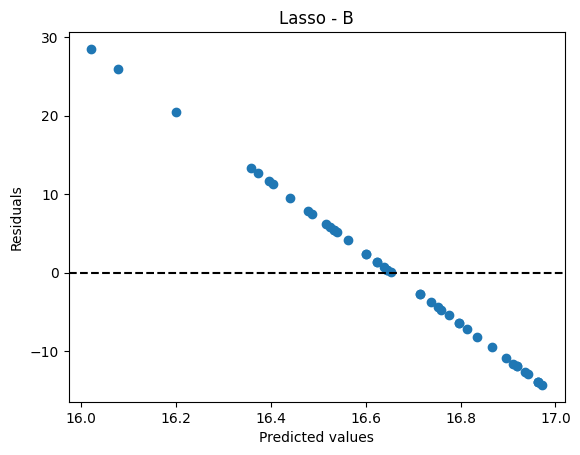

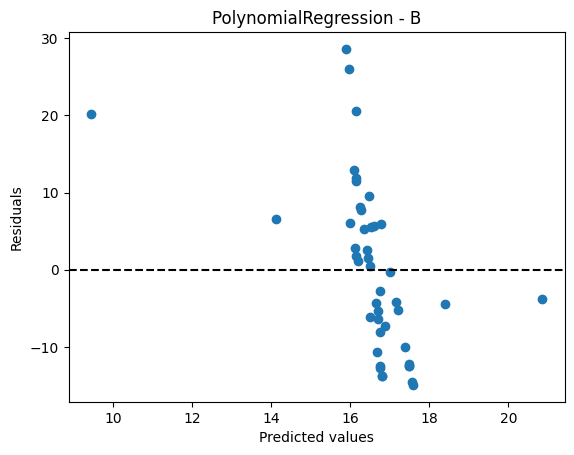

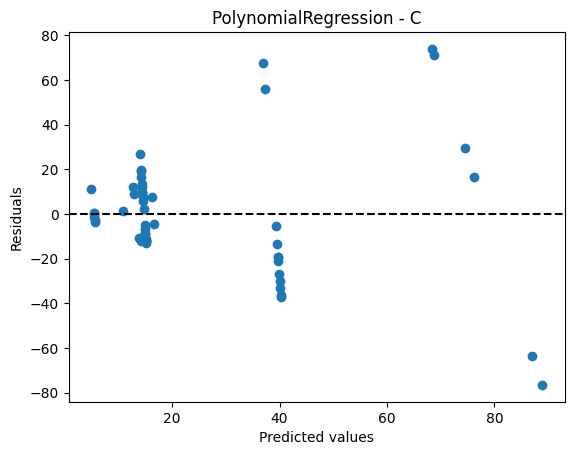

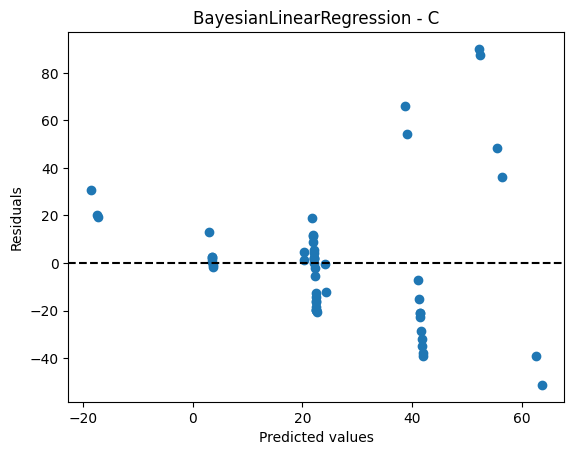

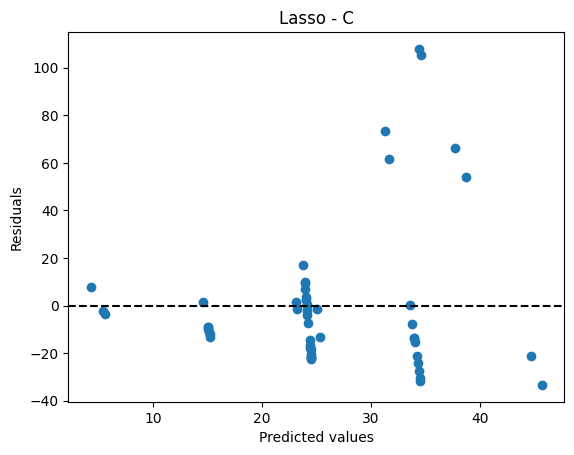

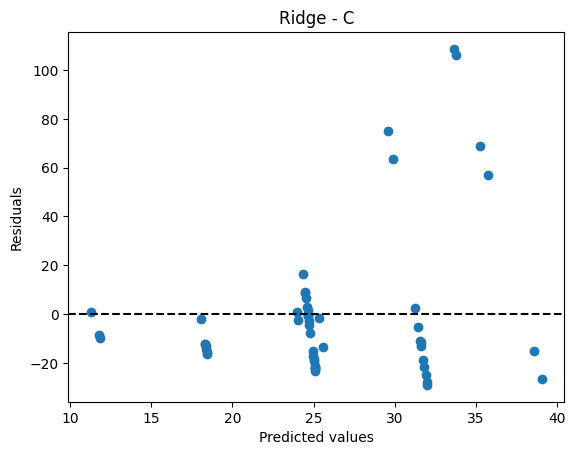

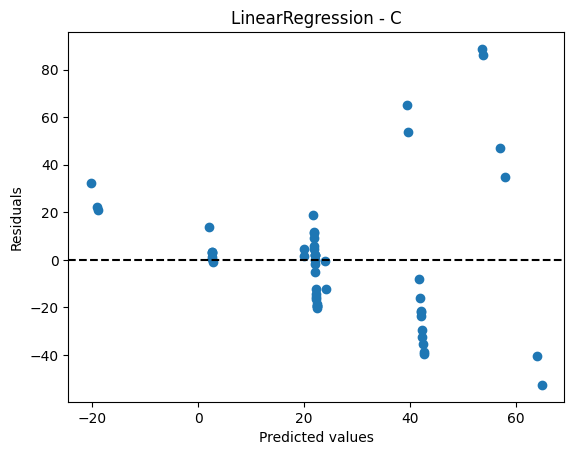

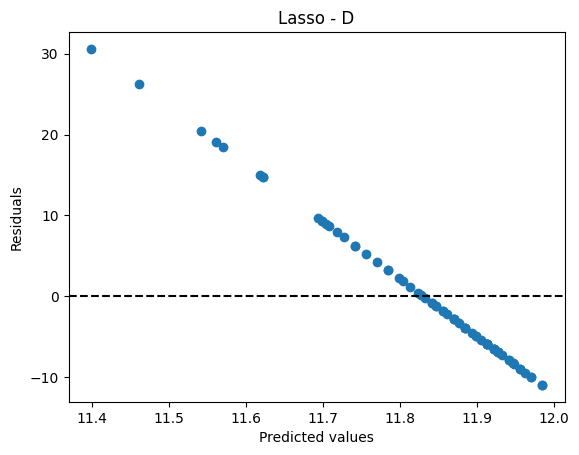

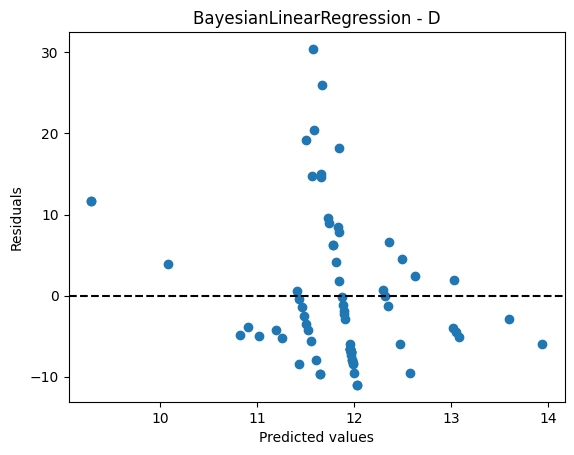

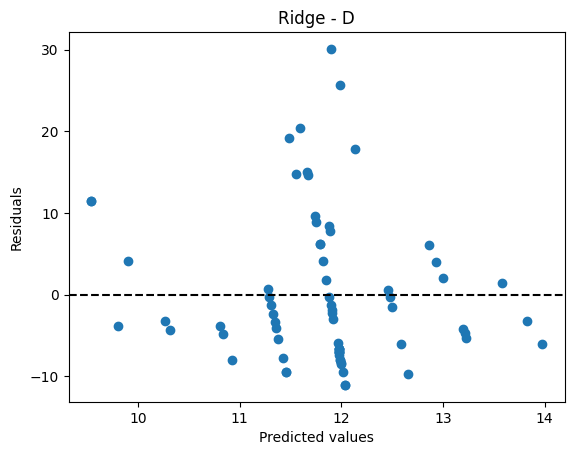

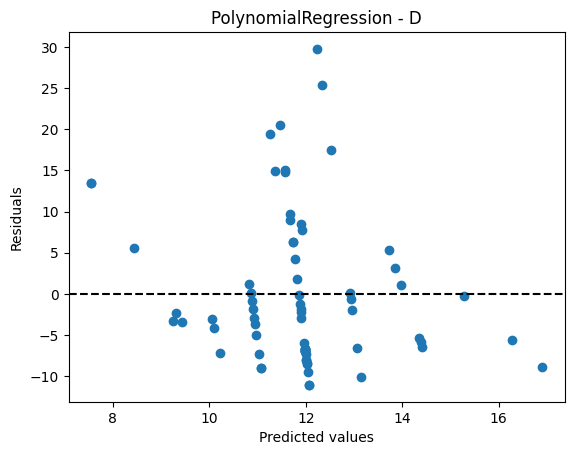

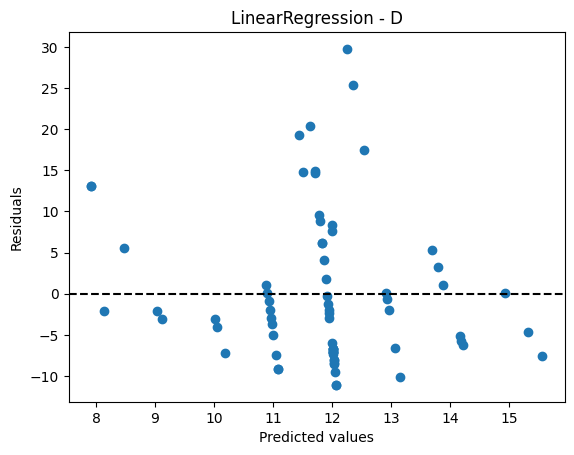

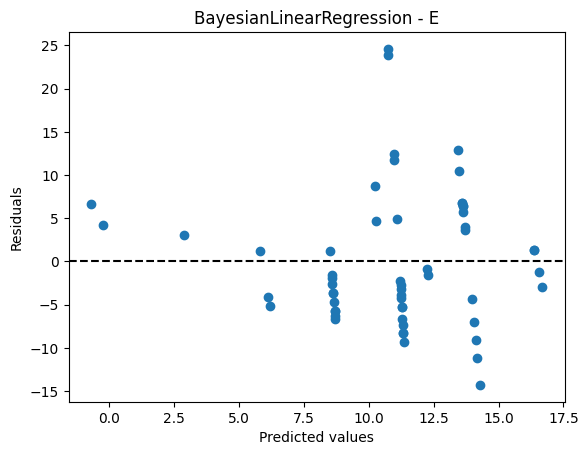

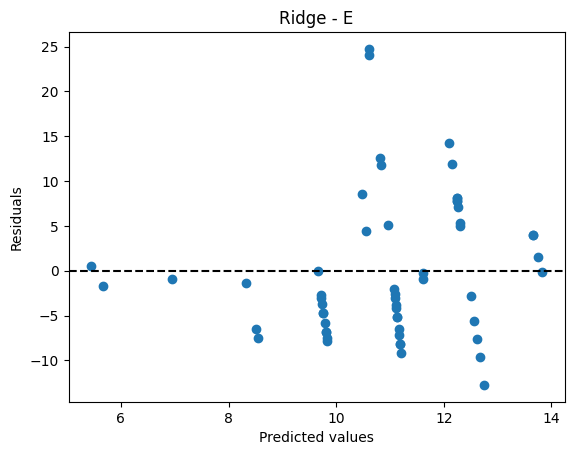

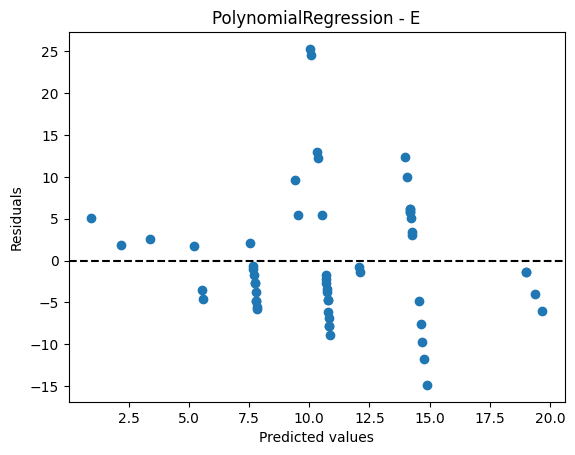

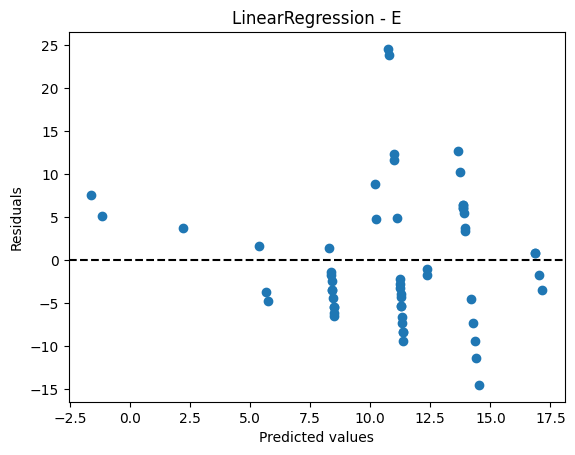

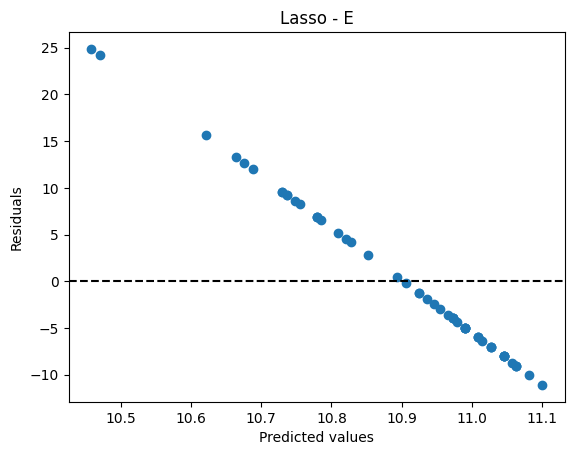

In [99]:
for site in df_results["Site"].unique():
    df_site = df_results[df_results["Site"] == site]
    for model in df_site["Model"].unique():
        df_model = df_site[df_site["Model"] == model]
        y_pred = df_model["y_pred"].values[0]
        residuals = df_model["Residuals"].values[0]
        plt.scatter(y_pred, residuals)
        plt.axhline(y=0.0, color="black", linestyle="--")
        plt.title(f"{model} - {site}")
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.show()

##### Predicted vs Actual

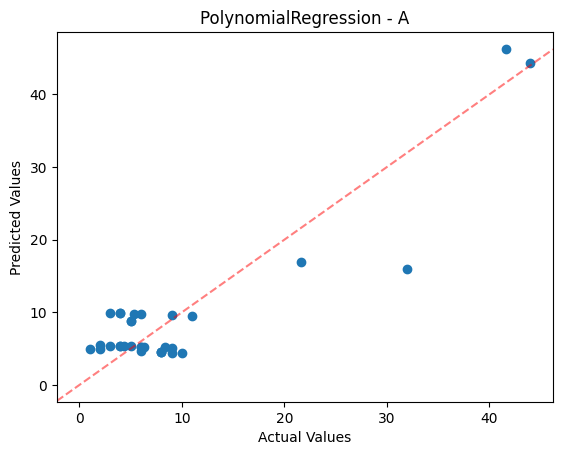

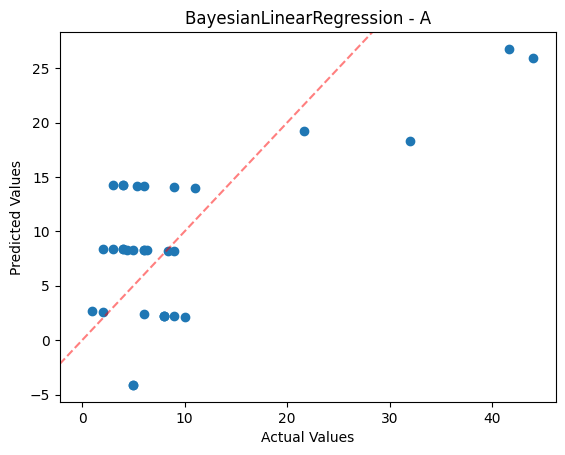

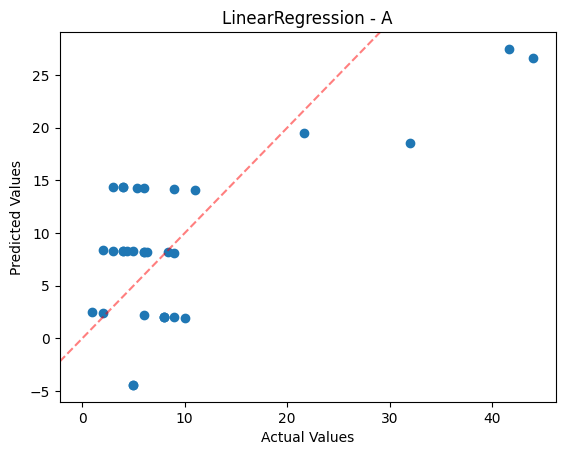

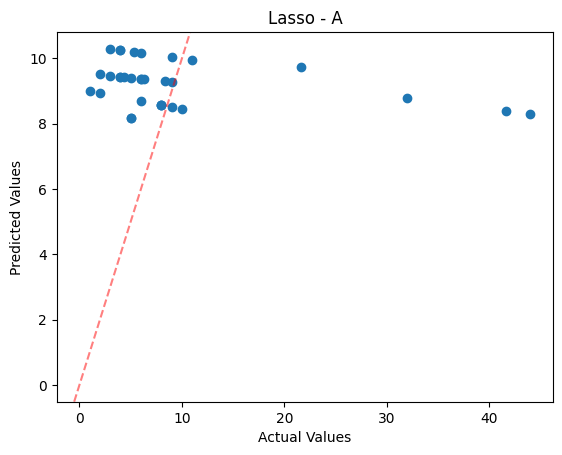

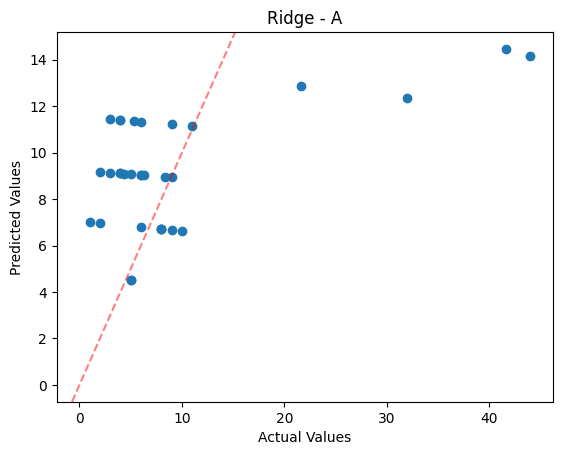

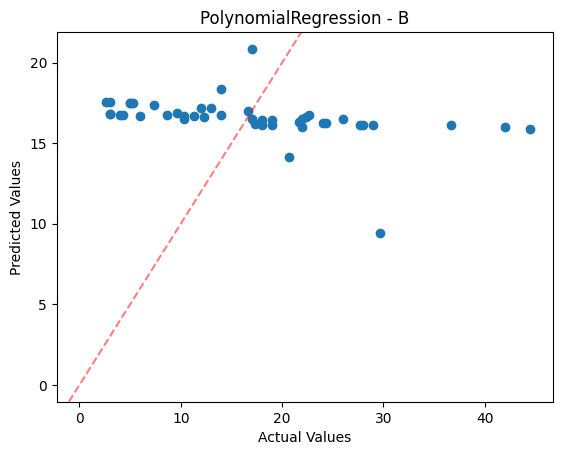

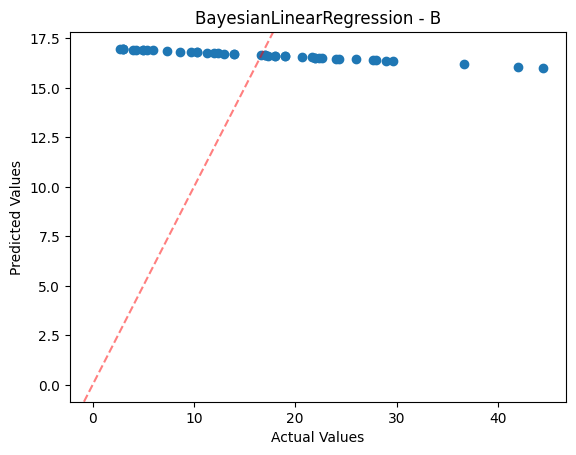

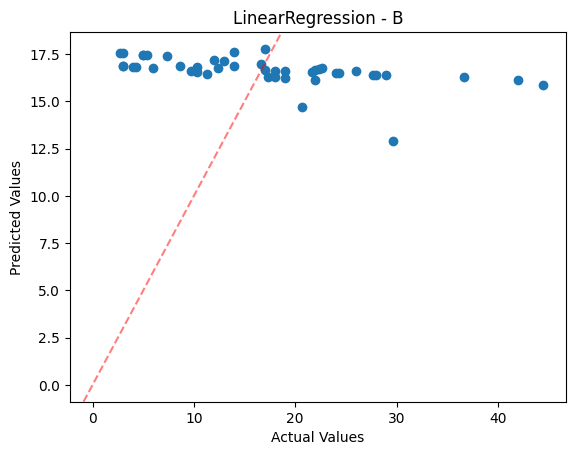

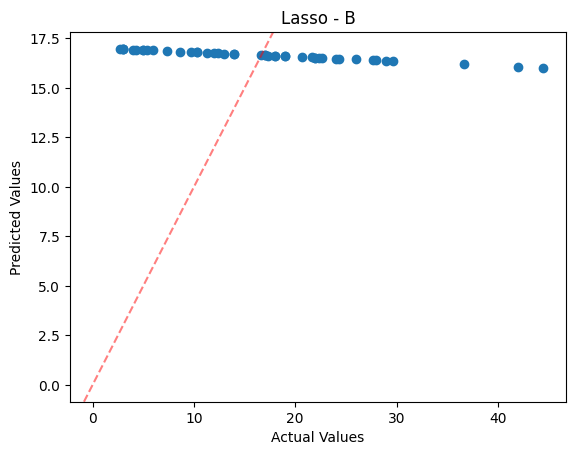

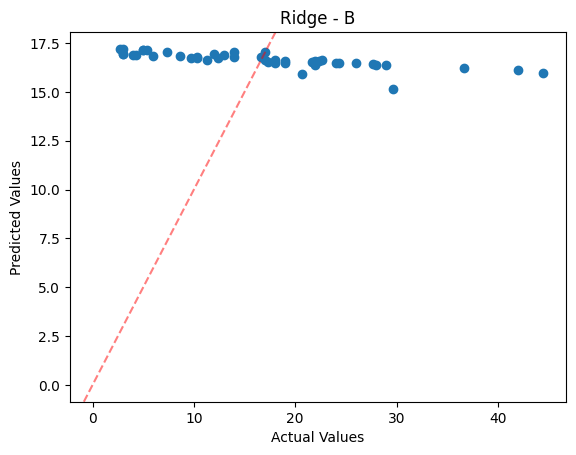

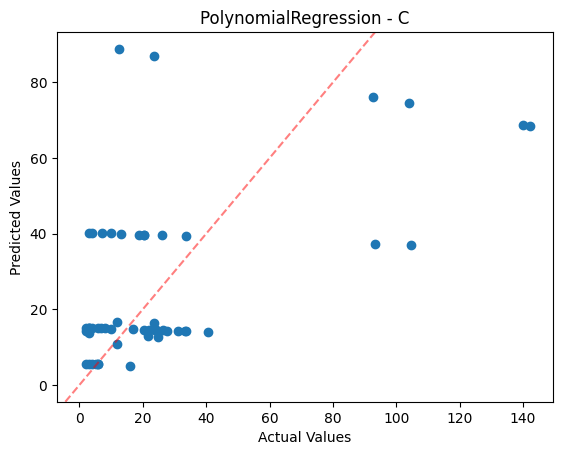

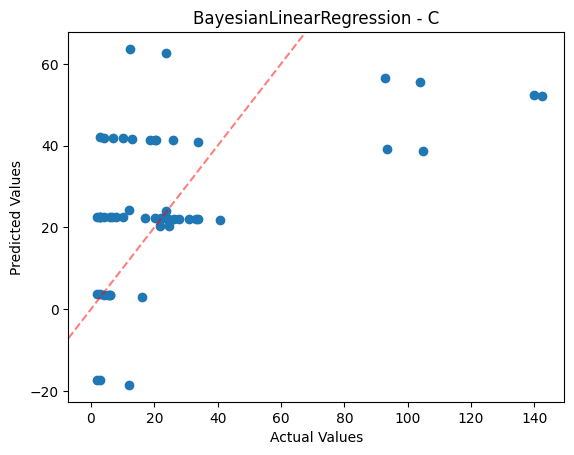

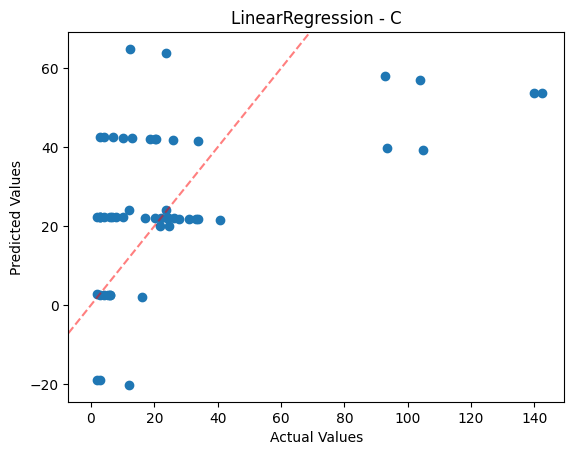

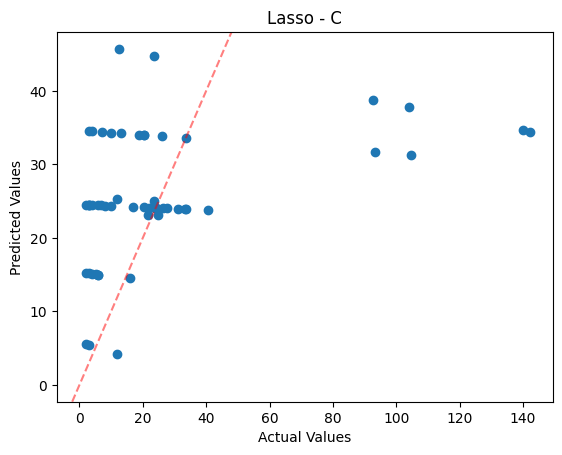

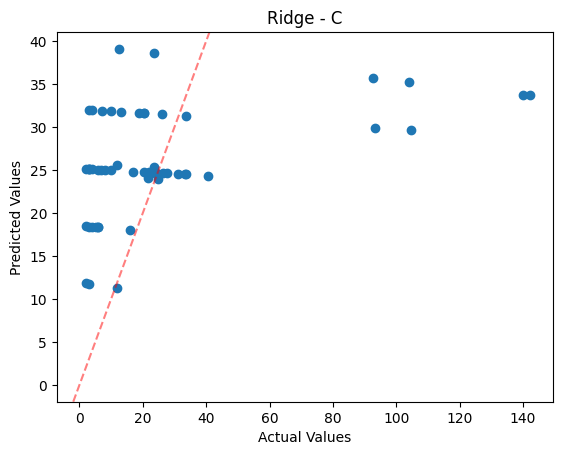

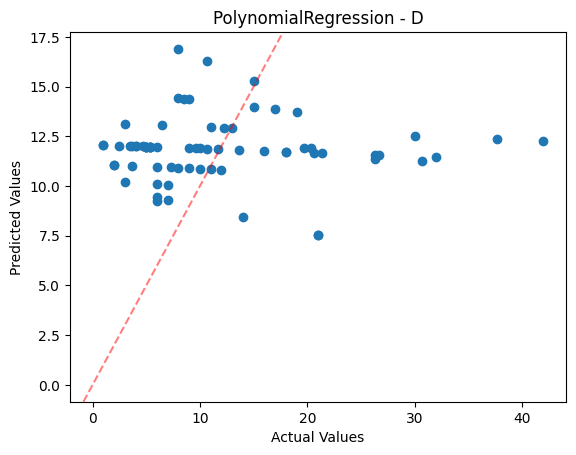

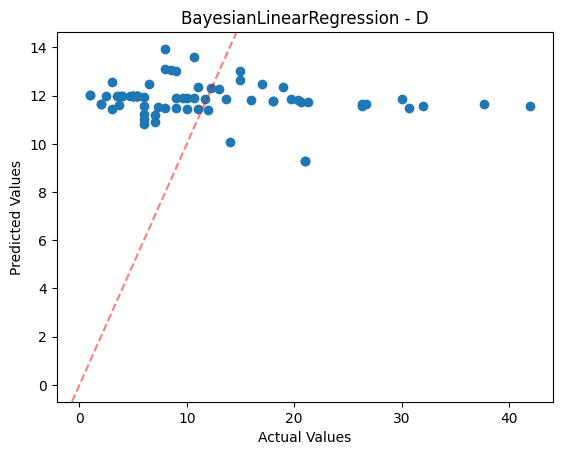

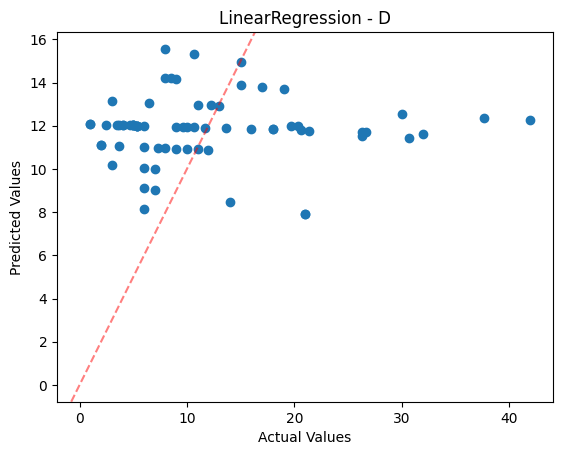

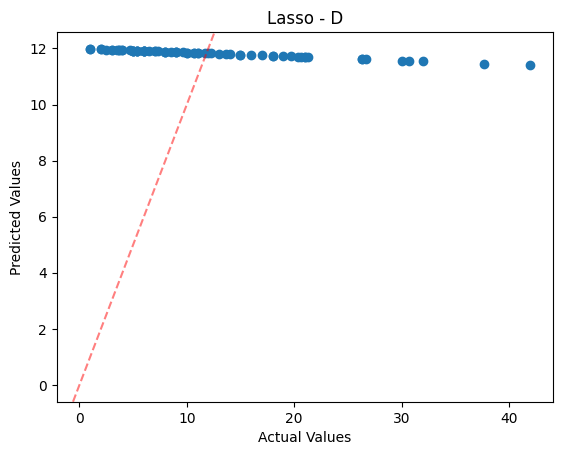

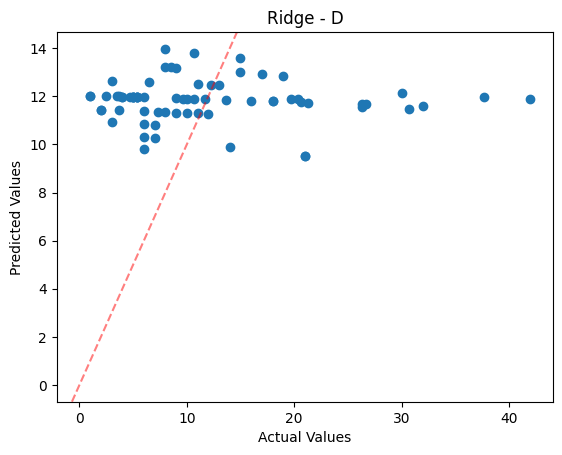

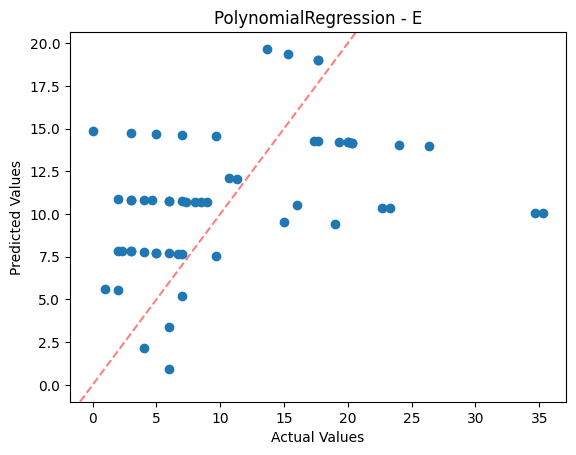

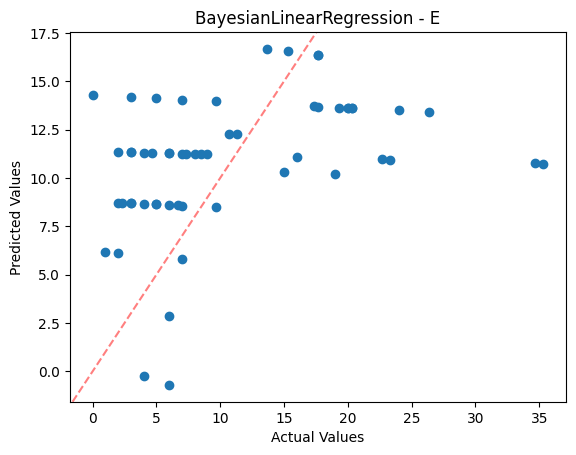

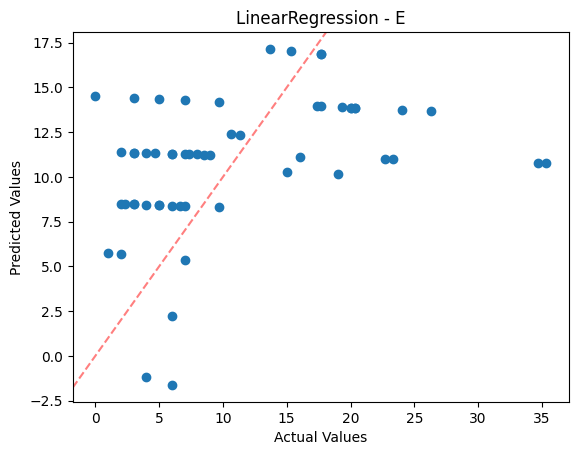

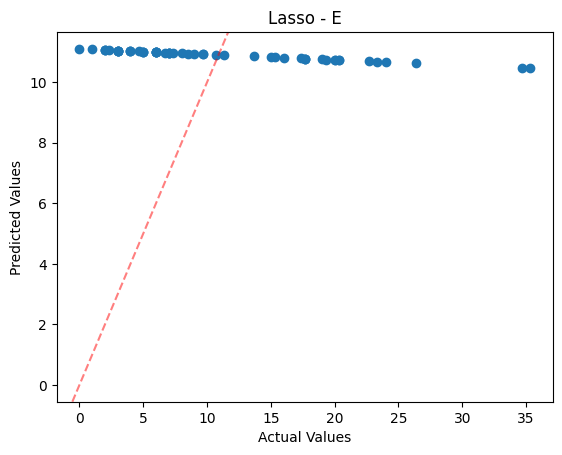

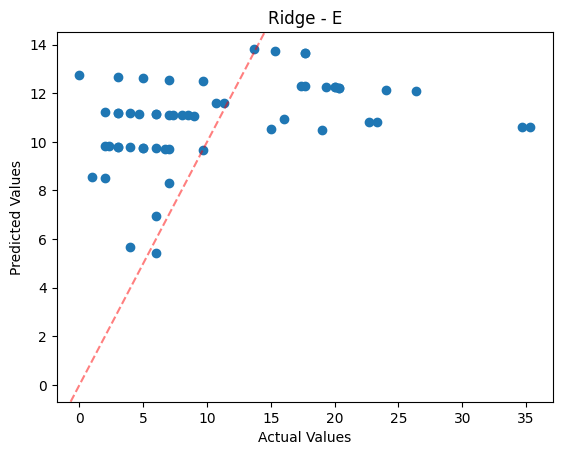

In [ ]:
for site in df_results["Site"].unique():
    for model in df_results["Model"].unique():
        y_test = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_true"].values[0]
        y_pred = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_pred"].values[0]

        plt.scatter(y_test, y_pred)
        plt.axline([0, 0], [1, 1], color="red", linestyle="--", alpha=0.5)
        plt.title(f"{model} - {site}")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.show()

### Cond (ms)

In [ ]:
cond_results = {}

In [ ]:
X, y = (
    ecoli_df[["Site", "Cond (ms)_mean"]],
    ecoli_df[["Site", "Ecoli (1ml)_mean"]],
)

#### Linear Regression

In [ ]:
cond_results["LinearRegression"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)
        # evaluate model
        yhat = lin_reg.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0][0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    cond_results["LinearRegression"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

#### Ridge Regression

In [ ]:
cond_results["Ridge"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        ridge = Ridge()
        ridge.fit(X_train, y_train)
        # evaluate model
        yhat = ridge.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0][0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    cond_results["Ridge"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

#### Lasso Regression

In [ ]:
cond_results["Lasso"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        lasso = Lasso()
        lasso.fit(X_train, y_train)
        # evaluate model
        yhat = lasso.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    cond_results["Lasso"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

#### Bayesian Linear Regression

In [ ]:
cond_results["BayesianLinearRegression"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        bayeasian_ridge = BayesianRidge()
        bayeasian_ridge.fit(X_train, y_train)
        # evaluate model
        yhat = bayeasian_ridge.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    cond_results["BayesianLinearRegression"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=T

#### Polynomial Regression

In [ ]:
cond_results["PolynomialRegression"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(X_site)
    poly_features = pd.DataFrame(poly_features)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(poly_features):
        # split data
        X_train, X_test = (
            poly_features.iloc[train_ix, :],
            poly_features.iloc[test_ix, :],
        )
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)
        # evaluate model
        yhat = lin_reg.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0][0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    cond_results["PolynomialRegression"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

#### Cond (ms) Results

In [ ]:
rows = []

for model in cond_results.keys():
    for site in cond_results[model].keys():
        row = {
            "Model": model,
            "Site": site,
            "MSE": cond_results[model][site]["mse"],
            "R2": cond_results[model][site]["r2"],
            "Residuals": cond_results[model][site]["residuals"],
            "y_pred": cond_results[model][site]["y_pred"],
            "y_true": cond_results[model][site]["y_true"],
        }
        rows.append(row)

df_results = pd.DataFrame(rows)
df_results.sort_values(by=["Site"], inplace=True)

In [ ]:
for site in df_results["Site"].unique():
    print(f"====================== Site: {site} ======================")
    for model in df_results["Model"].unique():
        print("MODEL:", model)
        y_test = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_true"].values[0]
        y_pred = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_pred"].values[0]
        regression_results(y_test, y_pred)
        print()

====================== Site: A ======================
MODEL: PolynomialRegression
r2:  0.7825
MAE:  3.093
MSE:  23.4156
RMSE:  4.839

MODEL: BayesianLinearRegression
r2:  0.5967
MAE:  4.8046
MSE:  43.4163
RMSE:  6.5891

MODEL: LinearRegression
r2:  0.5984
MAE:  4.8202
MSE:  43.225
RMSE:  6.5746

MODEL: Lasso
r2:  0.5418
MAE:  4.6569
MSE:  49.3201
RMSE:  7.0228

MODEL: Ridge
r2:  0.5909
MAE:  4.692
MSE:  44.0397
RMSE:  6.6362

====================== Site: B ======================
MODEL: PolynomialRegression
r2:  -0.1045
MAE:  8.7608
MSE:  116.1009
RMSE:  10.775

MODEL: BayesianLinearRegression
r2:  -0.046
MAE:  8.4309
MSE:  109.949
RMSE:  10.4857

MODEL: LinearRegression
r2:  -0.0704
MAE:  8.5939
MSE:  112.5156
RMSE:  10.6073

MODEL: Lasso
r2:  -0.046
MAE:  8.4308
MSE:  109.9477
RMSE:  10.4856

MODEL: Ridge
r2:  -0.0687
MAE:  8.5829
MSE:  112.3355
RMSE:  10.5988

====================== Site: C ======================
MODEL: PolynomialRegression
r2:  -0.139
MAE:  22.7946
MSE:  1265.4109
R

##### Estimated Functions

In [ ]:
%% script false --no-raise-error

# plot each estimated function and the real data points for each site
for site in df_results["Site"].unique():
    for model in df_results["Model"].unique():

        if model == "PolynomialRegression":
            result_model_site = df_results[
                (df_results["Site"] == site) & (df_results["Model"] == model)
            ]

            coefficients = result_model_site["Coefficients"].values[0]
            intercept = result_model_site["Intercept"].values[0]

            x_est = np.linspace(0, 30, 100)
            y_est = intercept + coefficients[0] * x_est + coefficients[1] * x_est ** 2

            plt.plot(x_est, y_est, label=model)
            plt.scatter(X[X["Site"] == site]["Cond (ms)_mean"], y[y['Site'] == site]['Ecoli (1ml)_mean'], label="Real Data")
            plt.title(f"Site: {site} - {model}")
        else:
            result_model_site = df_results[
                (df_results["Site"] == site) & (df_results["Model"] == model)
            ]

            coefficients = result_model_site["Coefficients"].values[0]
            intercept = result_model_site["Intercept"].values[0]

            x_est = np.linspace(0, 30, 100)
            y_est = intercept + coefficients[0] * x_est

            plt.plot(x_est, y_est, label=model)
            plt.scatter(X[X["Site"] == site]["Cond (ms)_mean"], y[y['Site'] == site]['Ecoli (1ml)_mean'], label="Real Data")
            plt.title(f"Site: {site} - {model}")
        plt.show()
        print()

UsageError: Cell magic `%%` not found.


##### Residuals

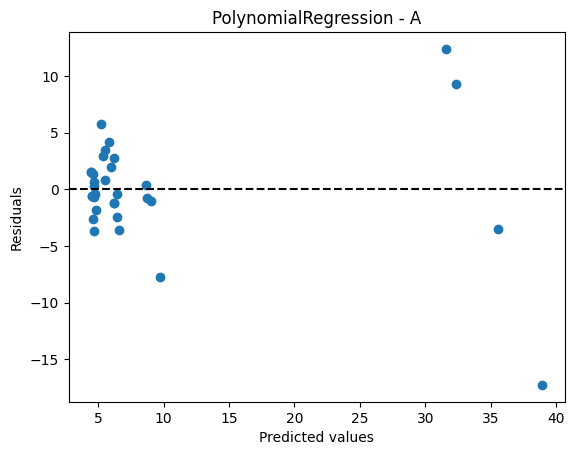

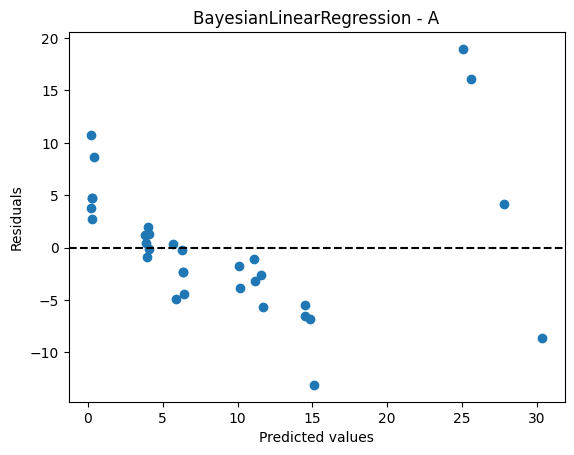

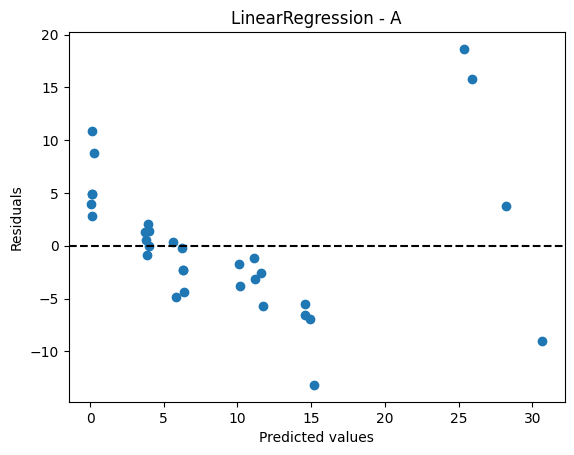

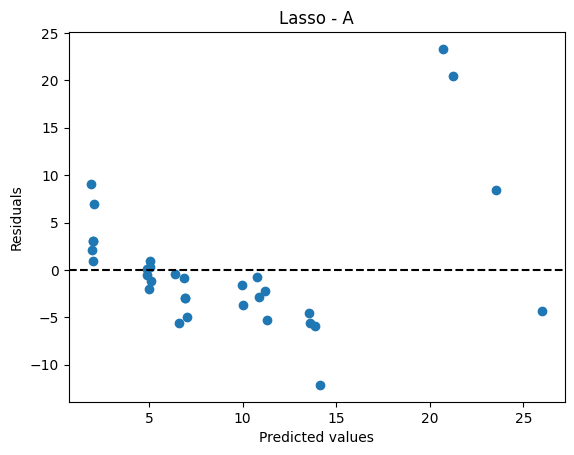

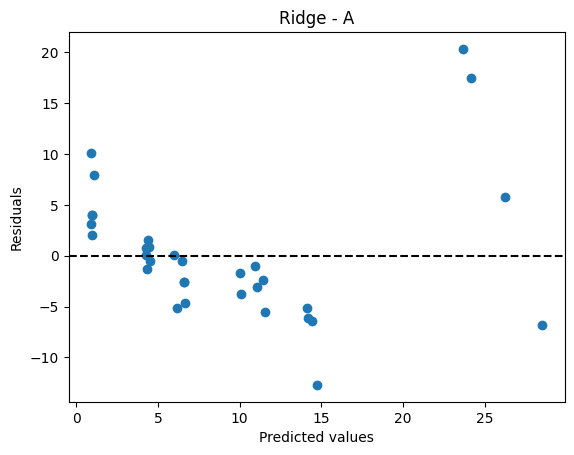

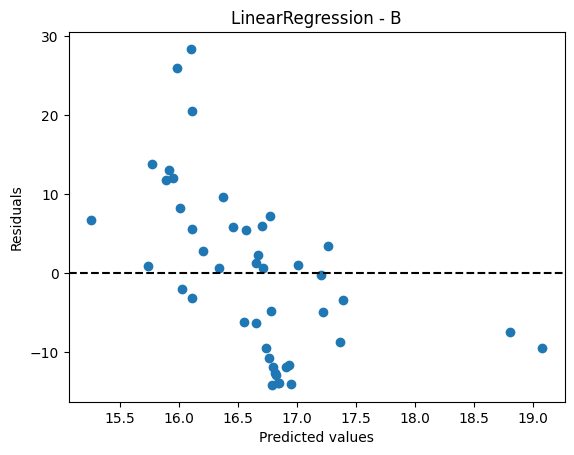

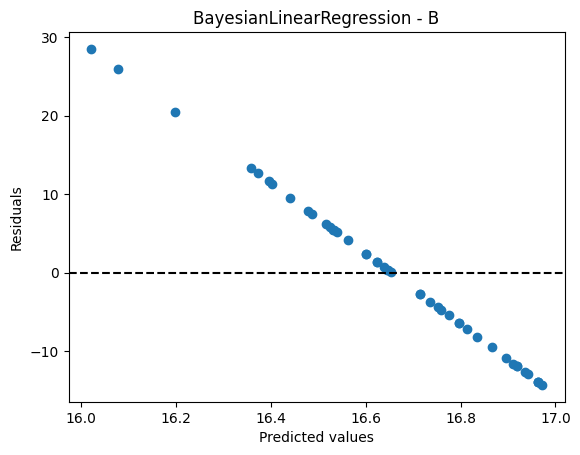

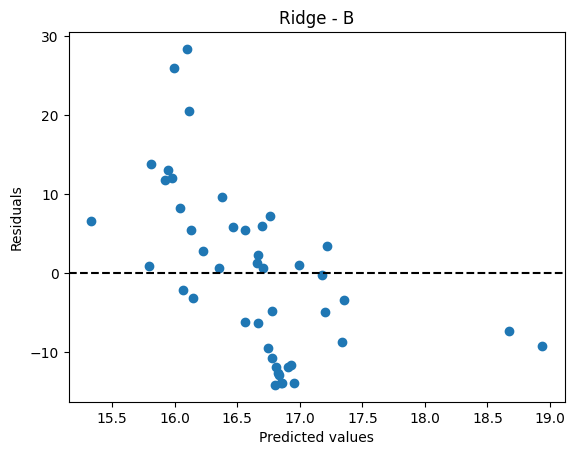

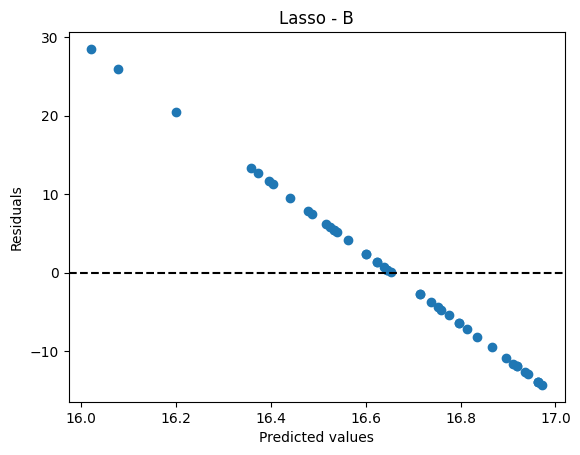

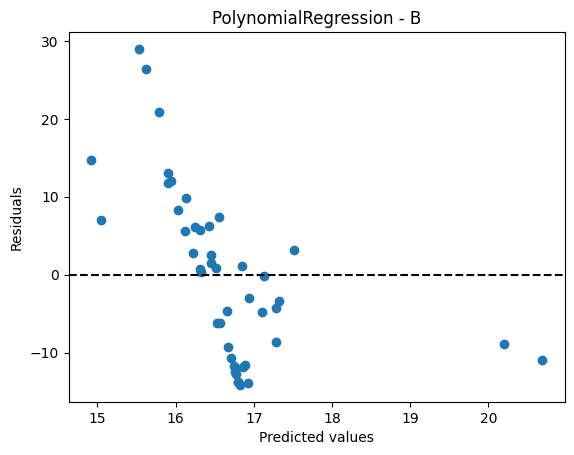

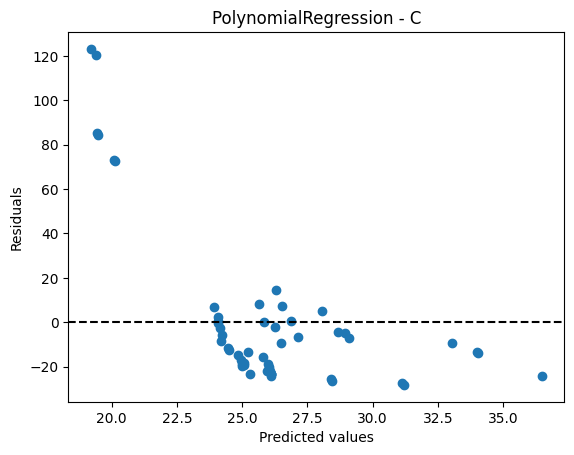

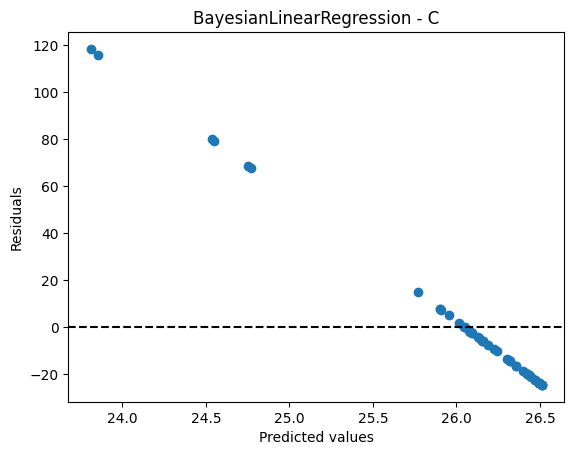

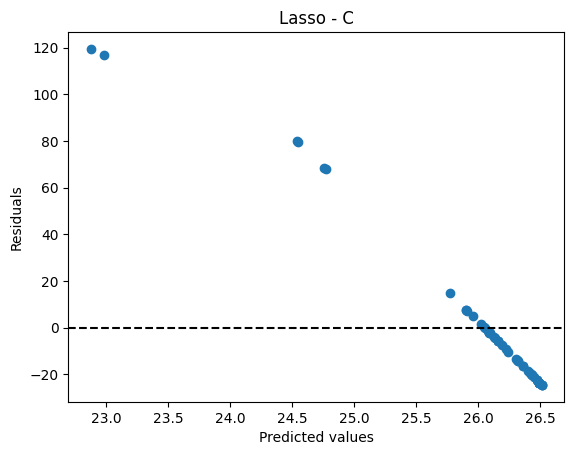

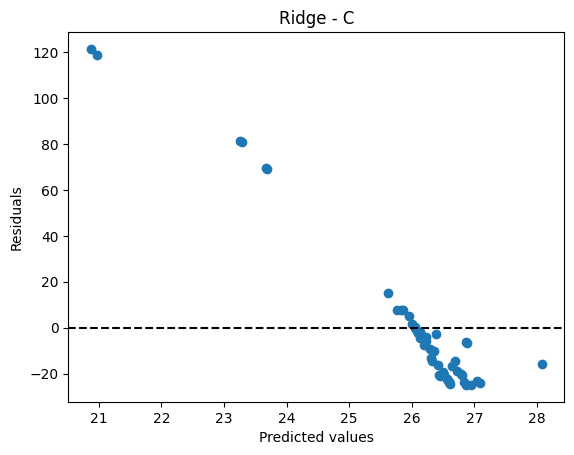

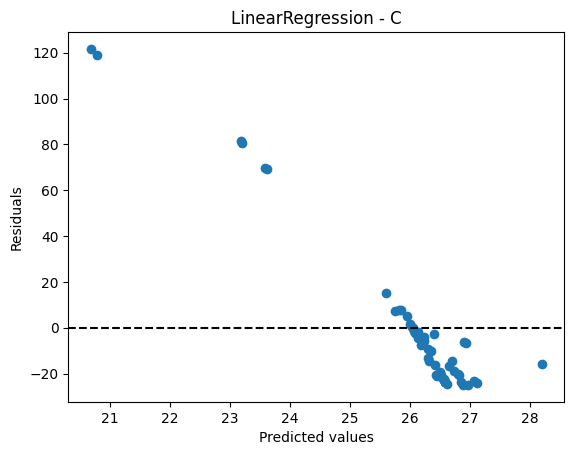

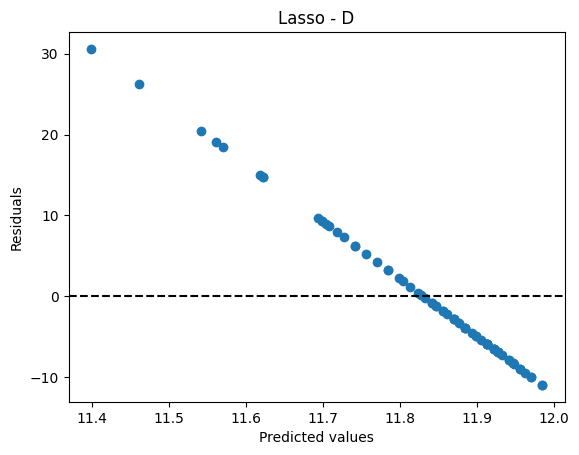

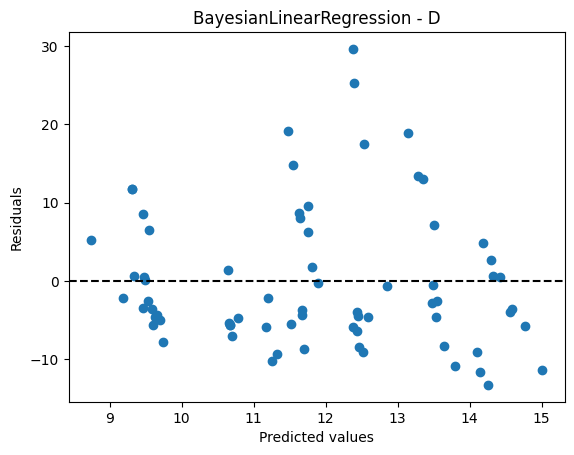

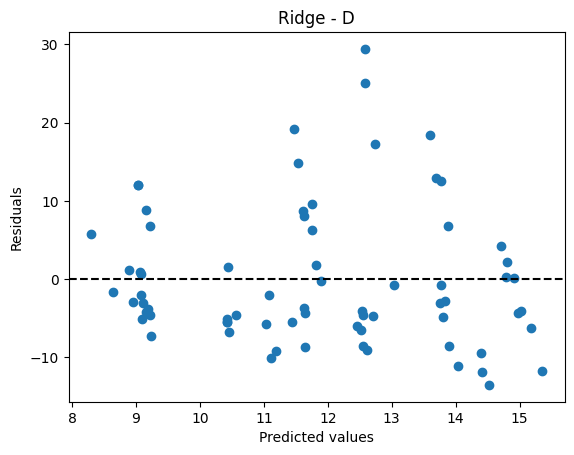

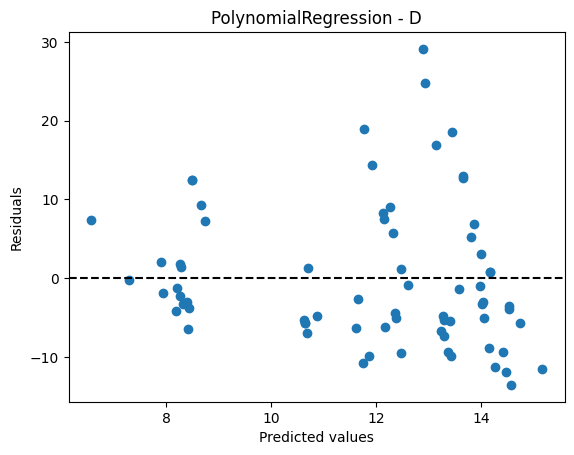

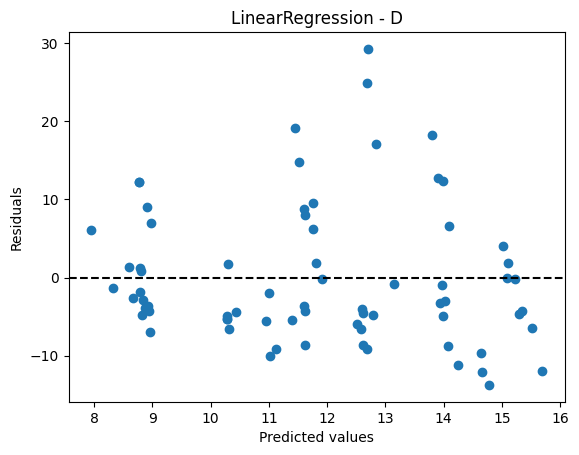

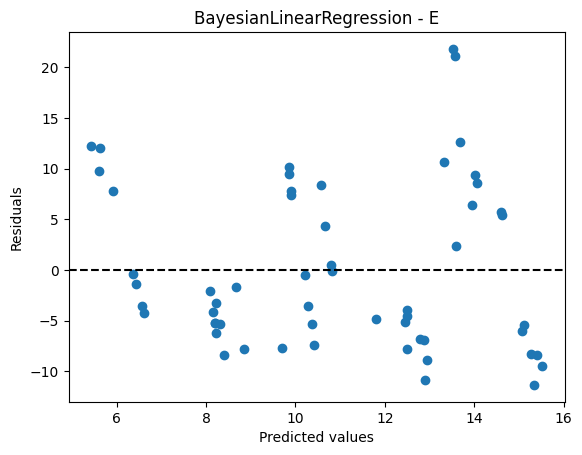

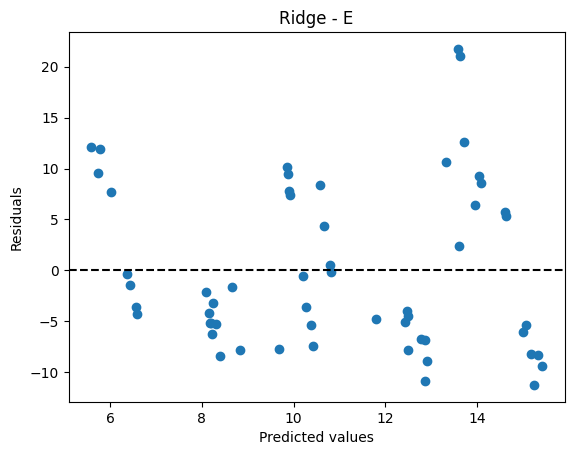

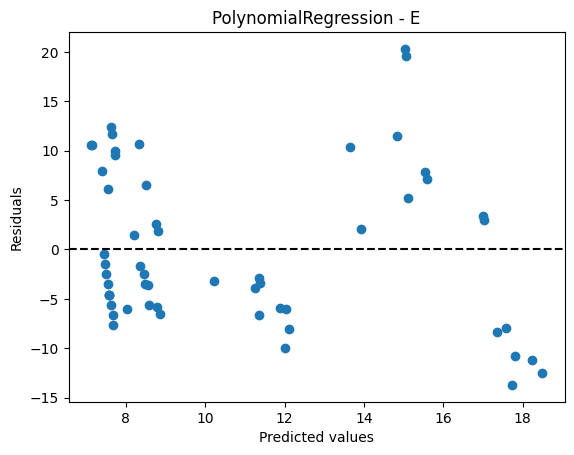

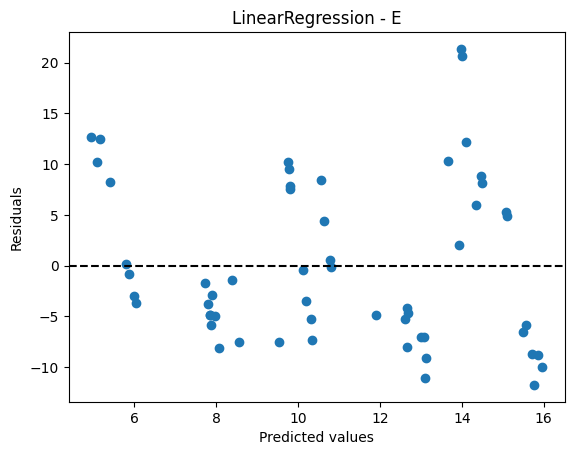

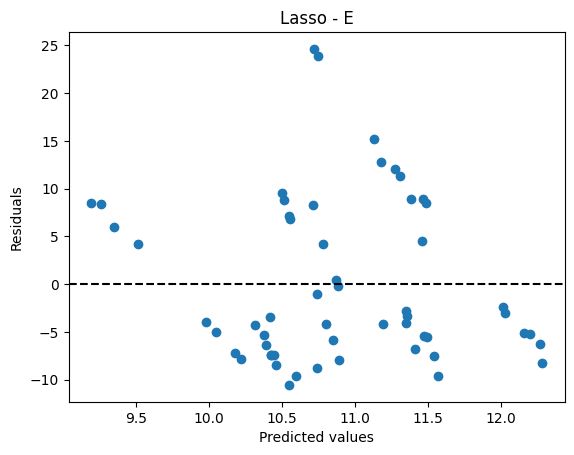

In [ ]:
for site in df_results["Site"].unique():
    df_site = df_results[df_results["Site"] == site]
    for model in df_site["Model"].unique():
        df_model = df_site[df_site["Model"] == model]
        y_pred = df_model["y_pred"].values[0]
        residuals = df_model["Residuals"].values[0]
        plt.scatter(y_pred, residuals)
        plt.axhline(y=0.0, color="black", linestyle="--")
        plt.title(f"{model} - {site}")
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.show()

##### Predicted vs Actual

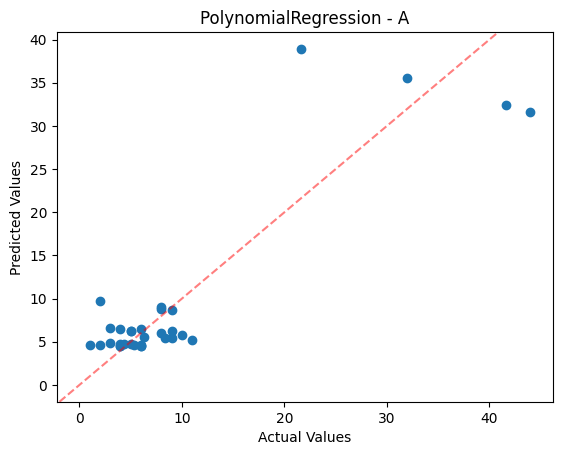

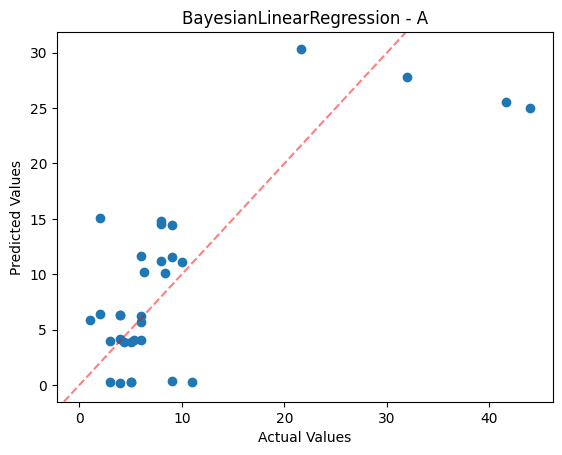

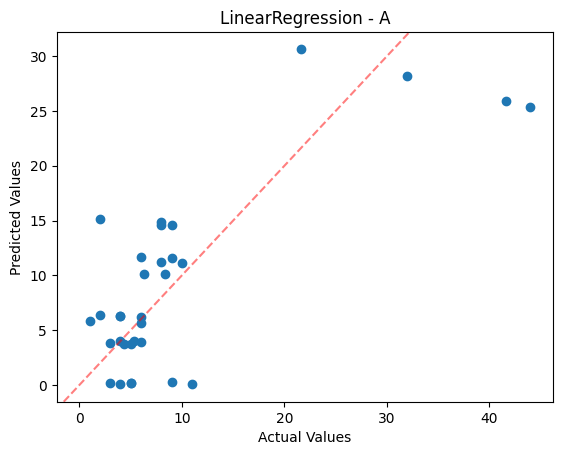

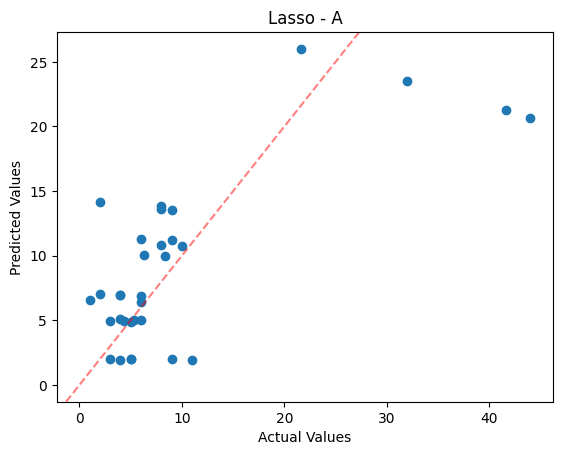

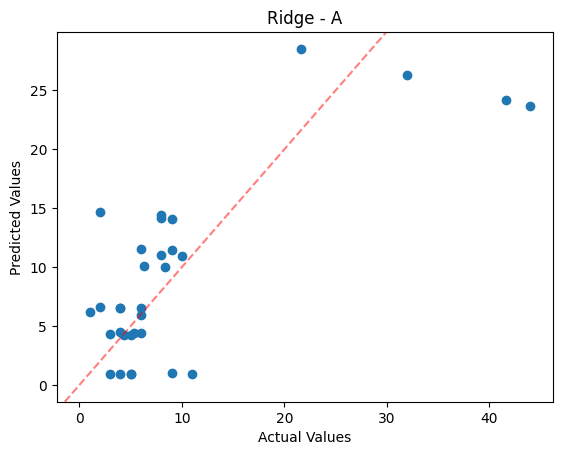

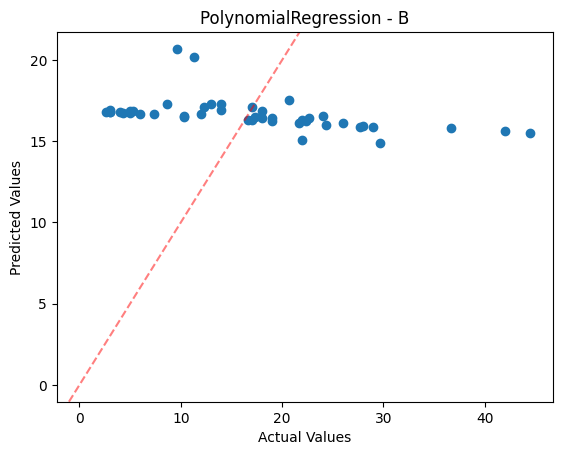

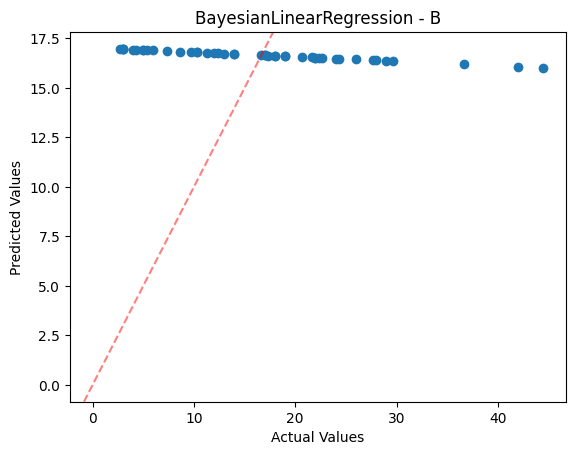

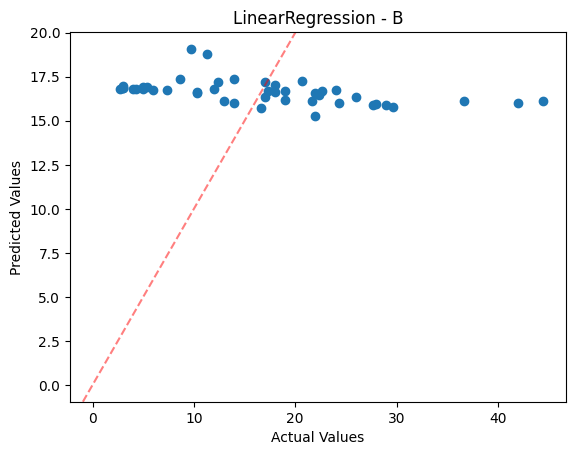

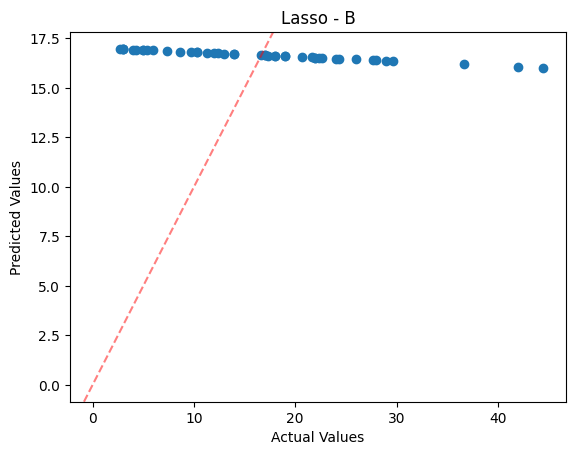

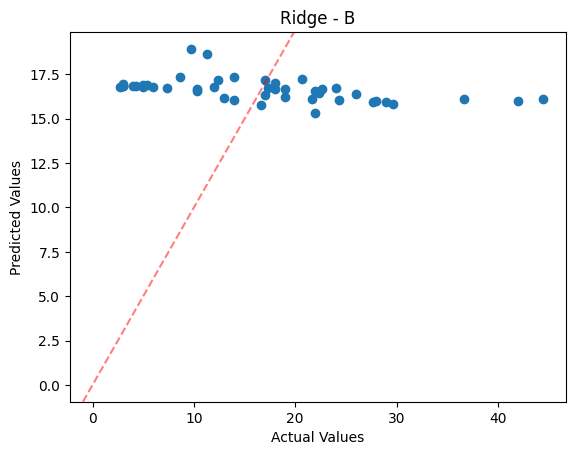

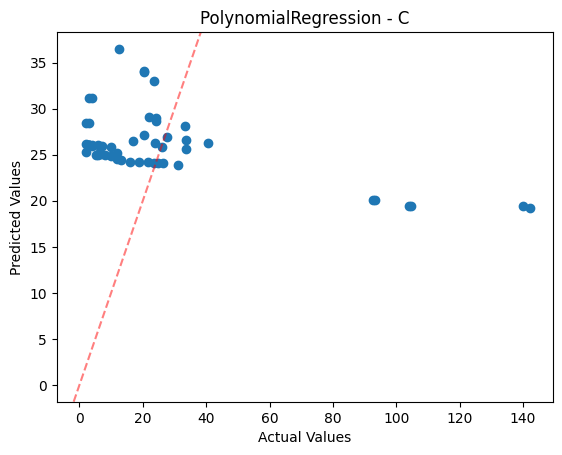

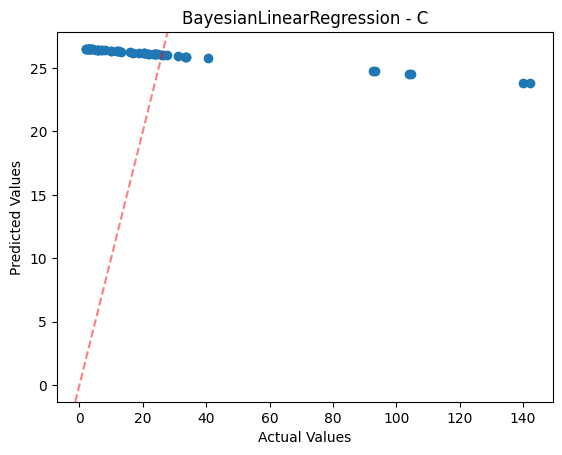

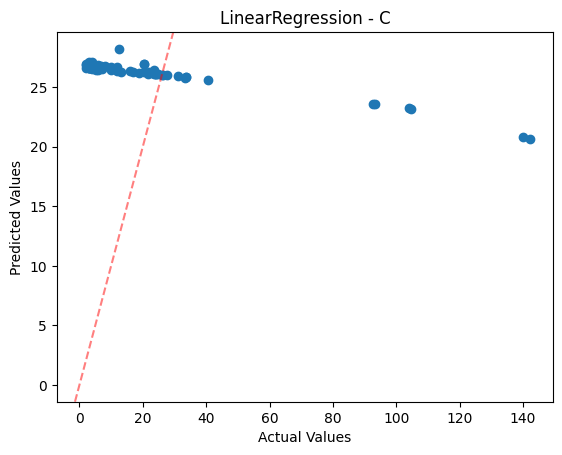

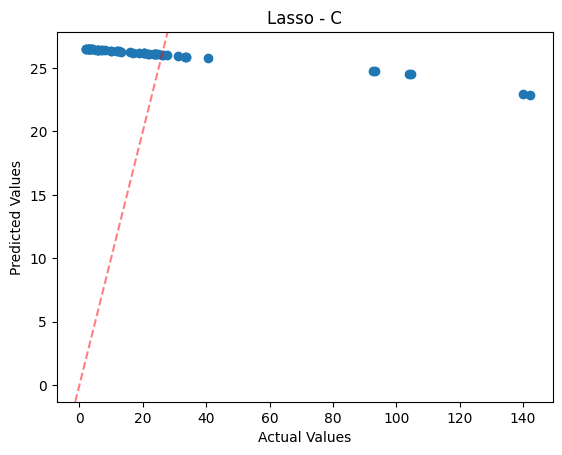

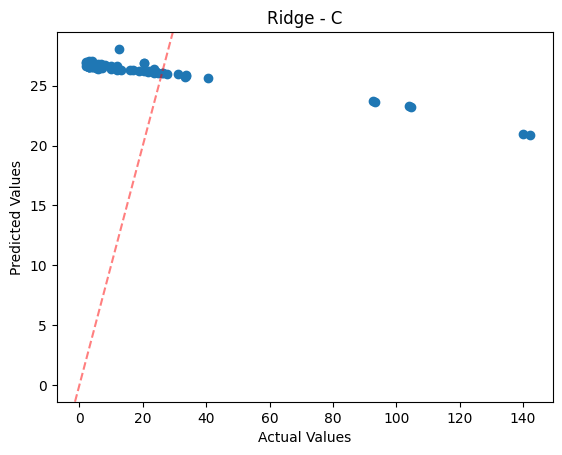

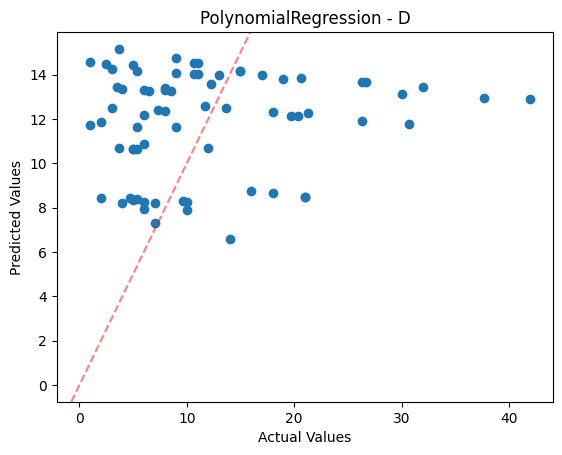

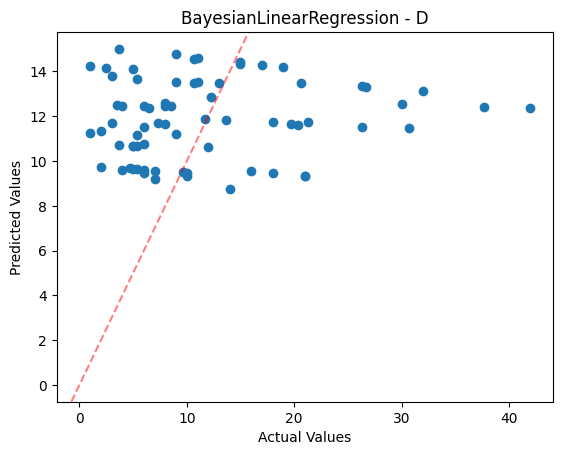

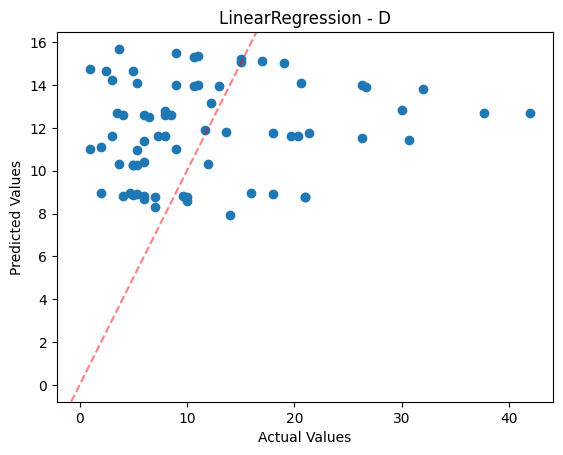

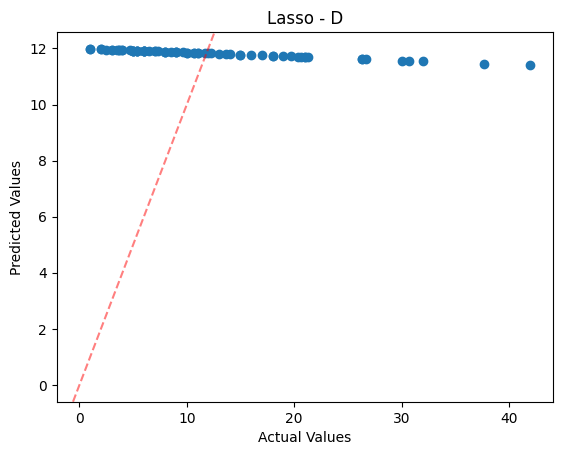

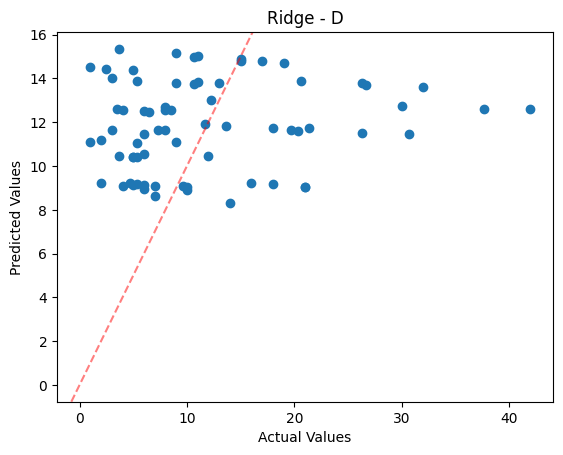

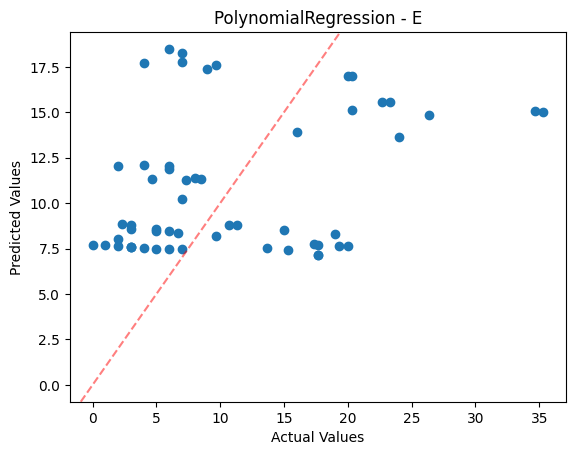

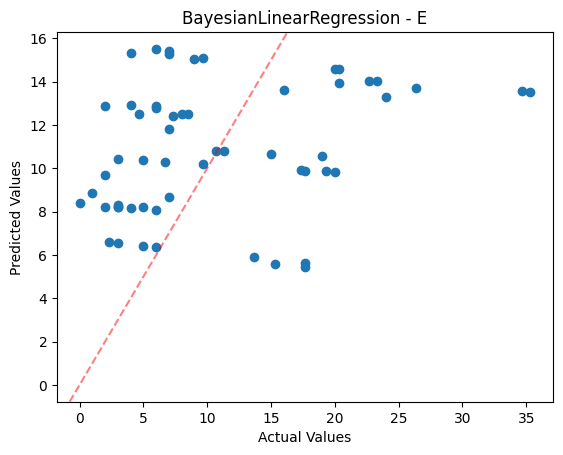

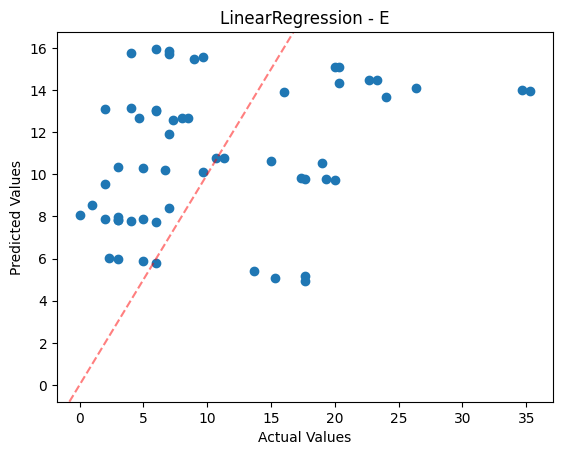

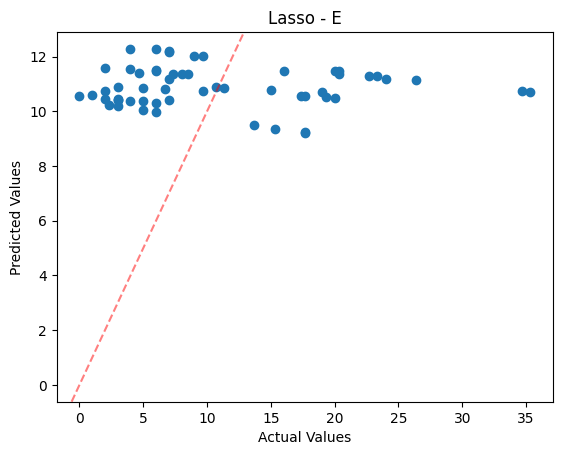

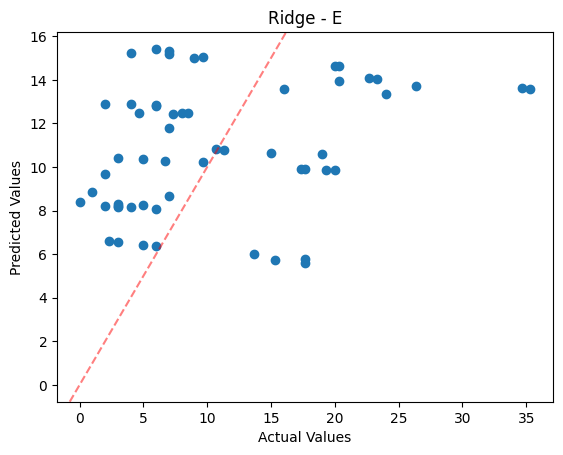

In [ ]:
for site in df_results["Site"].unique():
    for model in df_results["Model"].unique():
        y_test = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_true"].values[0]
        y_pred = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_pred"].values[0]

        plt.scatter(y_test, y_pred)
        plt.axline([0, 0], [1, 1], color="red", linestyle="--", alpha=0.5)
        plt.title(f"{model} - {site}")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.show()

## Overall Relationship

In [199]:
results = {}

In [200]:
ecoli_df.columns.to_list()

['DateTime',
 'Site',
 'Bottle',
 'Sample',
 'Technician Water Quality',
 'Technician Counting',
 'Temp C_mean',
 'Ph_mean',
 'Cond (ms)_mean',
 'Ecoli (1ml)_mean',
 'Deptford_rainfall_6h',
 'Holland Park_rainfall_6h',
 'Putney Heath_rainfall_6h',
 'Hogsmill Valley_rainfall_6h',
 'TideType_high',
 'TideType_low',
 'TideType_normal',
 'cso_active_False']

In [201]:
X, y = (
    ecoli_df.drop(columns=["Ecoli (1ml)_mean"]),
    ecoli_df[["Site", "Ecoli (1ml)_mean"]],
)
X = X[
    [
        "Site",
        "Temp C_mean",
        "Ph_mean",
        "Cond (ms)_mean",
        "Deptford_rainfall_6h",
        "Holland Park_rainfall_6h",
        "Putney Heath_rainfall_6h",
        "Hogsmill Valley_rainfall_6h",
        "TideType_high",
        "TideType_low",
        "TideType_normal",
        "cso_active_False",
    ]
]

### Linear Regression

In [202]:
results["LinearRegression"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)
        # evaluate model
        yhat = lin_reg.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0][0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    results["LinearRegression"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

### Ridge

In [203]:
# hyperparameter alpha fixed to 1.0 for the moment. Some tuning could be done.

results["Ridge"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        ridge = Ridge()
        ridge.fit(X_train, y_train)
        # evaluate model
        yhat = ridge.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0][0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    results["Ridge"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

### Lasso

In [204]:
# hyperparameter alpha fixed to 1.0 for the moment. Some tuning could be done.

results["Lasso"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        lasso = Lasso()
        lasso.fit(X_train, y_train)
        # evaluate model
        yhat = lasso.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    results["Lasso"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

### Bayesian Linear Regression

In [205]:
# # hyperparameters fixed to default values for the moment. Some tuning could be done.

results["BayesianLinearRegression"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X_site):
        # split data
        X_train, X_test = X_site.iloc[train_ix, :], X_site.iloc[test_ix, :]
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        bayesian_ridge = BayesianRidge()
        bayesian_ridge.fit(X_train, y_train)
        # evaluate model
        yhat = bayesian_ridge.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    results["BayesianLinearRegression"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/thames-XkegVY7k-py3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=T

### Polynomial Regression

In [206]:
# here the hyperparameter is the degree of the polynomial features. For the moment it is fixed to 2. Some tuning could be done.

results["PolynomialRegression"] = {}

for site in X["Site"].unique():
    X_site = X[X["Site"] == site]
    X_site.drop(columns=["Site"], inplace=True)

    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(X_site)
    poly_features = pd.DataFrame(poly_features)

    y_site = y[y["Site"] == site]
    y_site.drop(columns=["Site"], inplace=True)

    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(poly_features):
        # split data
        X_train, X_test = (
            poly_features.iloc[train_ix, :],
            poly_features.iloc[test_ix, :],
        )
        y_train, y_test = y_site.iloc[train_ix], y_site.iloc[test_ix]
        # fit model
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)
        # evaluate model
        yhat = lin_reg.predict(X_test)
        # store
        y_true.append(y_test.iloc[0].values[0])
        y_pred.append(yhat[0][0])

    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    results["PolynomialRegression"][site] = {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "residuals": residuals,
        "y_pred": y_pred,
        "y_true": y_true,
    }

### Results

In [207]:
rows = []

for model in results.keys():
    for site in results[model].keys():
        row = {
            "Model": model,
            "Site": site,
            "MSE": results[model][site]["mse"],
            "R2": results[model][site]["r2"],
            "Residuals": results[model][site]["residuals"],
            "y_pred": results[model][site]["y_pred"],
            "y_true": results[model][site]["y_true"],
        }
        rows.append(row)

df_results = pd.DataFrame(rows)
df_results.sort_values(by=["Site"], inplace=True)

In [208]:
df_results

Model Site          MSE        R2  \
3           LinearRegression    A    32.386170  0.699127   
18  BayesianLinearRegression    A    31.184705  0.710288   
8                      Ridge    A    33.484687  0.688921   
13                     Lasso    A    48.413905  0.550226   
23      PolynomialRegression    A    13.036208  0.878891   
24      PolynomialRegression    B    70.789499  0.355493   
19  BayesianLinearRegression    B    69.426596  0.367901   
4           LinearRegression    B    80.063835  0.271054   
14                     Lasso    B    74.788334  0.319085   
9                      Ridge    B    68.927773  0.372443   
20      PolynomialRegression    C    35.997005  0.968655   
15  BayesianLinearRegression    C  1200.394285 -0.045249   
0           LinearRegression    C   464.302976  0.595706   
10                     Lasso    C  1061.783210  0.075447   
5                      Ridge    C   866.672333  0.245341   
6                      Ridge    D    73.696847  0.174049   
16  BayesianLinearRegression    D    75.915526  0.149183   
1           LinearRegression    D    87.490047  0.019463   
21      PolynomialRegression    D   259.007189 -1.902801   
11                     Lasso    D    93.648275 -0.049555   
7                      Ridge    E    56.178297  0.213440   
17  BayesianLinearRegression    E    64.522745  0.096608   
2           LinearRegression    E    54.742101  0.233548   
22      PolynomialRegression    E   251.310626 -2.518634   
12                     Lasso    E    72.238255 -0.011418   

                                            Residuals  \
3   [-2.0, 2.0000000000000284, 10.657571392585453,...   
18  [-0.4184459972405534, 2.318555375497141, 8.603...   
8   [-2.952764270291013, -0.6158756994101964, 6.36...   
13  [-3.8117365295876464, -1.657369122674055, 3.54...   
23  [-1.98974609375, 2.02099609375, 0.00537109375,...   
24  [21.833333333328483, -21.833333333336057, -34....   
19  [22.996079175937822, -0.27134577095277024, -12...   
4   [26.018794964619076, 0.2891039799638975, -19.2...   
14  [24.3848709127566, 1.5588227267776773, -12.573...   
9   [23.12401441443883, -0.40652819602317436, -13....   
20  [-9.000000000465661, 8.999999998370185, -2.249...   
15  [-2.3260054661105194, 6.858054454264252, -4.62...   
0   [-2.572665016956762, 9.419791762256637, -5.522...   
10  [2.5543354761373394, 13.686050152669395, -0.22...   
5   [4.3159839574705074, 15.49351745659169, 1.4502...   
6   [4.968551898750121, 11.523710164625442, 17.164...   
16  [5.906958490154388, 12.457332162019092, 18.098...   
1   [2.889958797724333, 9.666948667906198, 15.3607...   
21  [-6.518881391957009, 1.4206771552368735, 6.323...   
11  [8.94911750415787, 15.069256535795045, 20.5093...   
7   [-6.188375183376593, -3.552101332595811, -5.98...   
17  [-6.051007320755588, -3.241487117159707, -5.97...   
2   [-11.385994921727331, 6.124237711572505, 3.191...   
22  [108.5722327484782, 2.016130278498167, -1.9838...   
12  [-8.558637531362447, -5.53158320771394, -7.591...   

                                               y_pred  \
3   [10.0, 7.999999999999972, -5.657571392585453, ...   
18  [8.418445997240553, 7.681444624502859, -3.6038...   
8   [10.952764270291013, 10.615875699410196, -1.36...   
13  [11.811736529587646, 11.657369122674055, 1.454...   
23  [9.98974609375, 7.97900390625, 4.99462890625, ...   
24  [22.666666666671517, 44.50000000000273, 37.483...   
19  [21.503920824062178, 22.93801243761944, 15.510...   
4   [18.481205035380924, 22.377562686702774, 21.93...   
14  [20.1151290872434, 21.107843939888994, 15.2397...   
9   [21.37598558556117, 23.073194862689846, 15.956...   
20  [33.25000000046566, 24.250000001629815, 24.249...   
15  [26.57600546611052, 26.391945545735748, 26.623...   
0   [26.822665016956762, 23.830208237743363, 27.52...   
10  [21.69566452386266, 19.563949847330605, 22.228...   
5   [19.934016042529493, 17.75648254340831, 20.549...   
6   [15.69811476791655, 15.14295650204123, 14.8355...   
16  [14.75

In [209]:
for site in df_results["Site"].unique():
    print(f"====================== Site: {site} ======================")
    for model in df_results["Model"].unique():
        print("MODEL:", model)
        y_test = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_true"].values[0]
        y_pred = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_pred"].values[0]
        regression_results(y_test, y_pred)
        print()

====================== Site: A ======================
MODEL: LinearRegression
r2:  0.6991
MAE:  4.3396
MSE:  32.3862
RMSE:  5.6909

MODEL: BayesianLinearRegression
r2:  0.7103
MAE:  4.0723
MSE:  31.1847
RMSE:  5.5843

MODEL: Ridge
r2:  0.6889
MAE:  4.2505
MSE:  33.4847
RMSE:  5.7866

MODEL: Lasso
r2:  0.5502
MAE:  4.642
MSE:  48.4139
RMSE:  6.958

MODEL: PolynomialRegression
r2:  0.8789
MAE:  2.6238
MSE:  13.0362
RMSE:  3.6106

====================== Site: B ======================
MODEL: LinearRegression
r2:  0.2711
MAE:  6.8389
MSE:  80.0638
RMSE:  8.9478

MODEL: BayesianLinearRegression
r2:  0.3679
MAE:  6.5924
MSE:  69.4266
RMSE:  8.3323

MODEL: Ridge
r2:  0.3724
MAE:  6.4598
MSE:  68.9278
RMSE:  8.3023

MODEL: Lasso
r2:  0.3191
MAE:  7.0352
MSE:  74.7883
RMSE:  8.648

MODEL: PolynomialRegression
r2:  0.3555
MAE:  5.5408
MSE:  70.7895
RMSE:  8.4136

====================== Site: C ======================
MODEL: LinearRegression
r2:  0.5957
MAE:  15.6262
MSE:  464.303
RMSE:  21.5477

M

#### Coefficients plots

In [148]:
%%script false --no-raise-error

for site in df_results["Site"].unique():
    df_site = df_results[df_results["Site"] == site]
    for model in df_site["Model"].unique():
        df_model = df_site[df_site["Model"] == model]
        x_axis = range(len(df_model["Coefficients"].values[0]))
        plt.figure(figsize=(5, 2))
        plt.bar(x_axis, df_model["Coefficients"].values[0])
        plt.title(f"{model} - {site}")
        plt.show()

#### Residuals

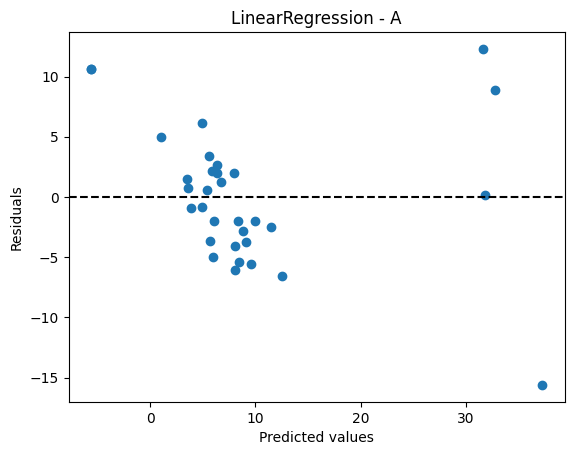

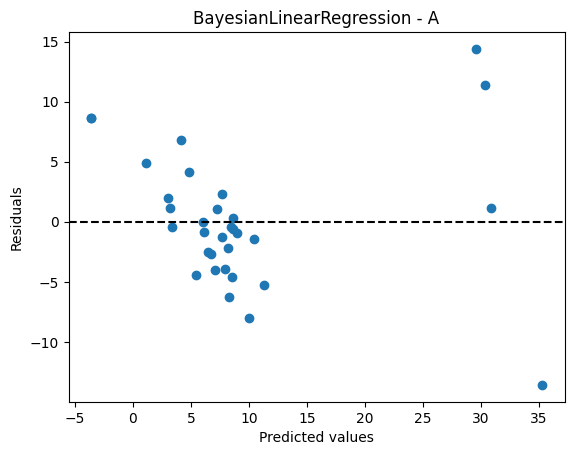

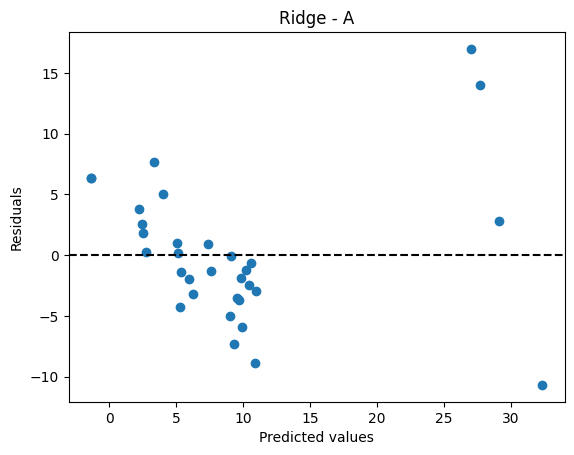

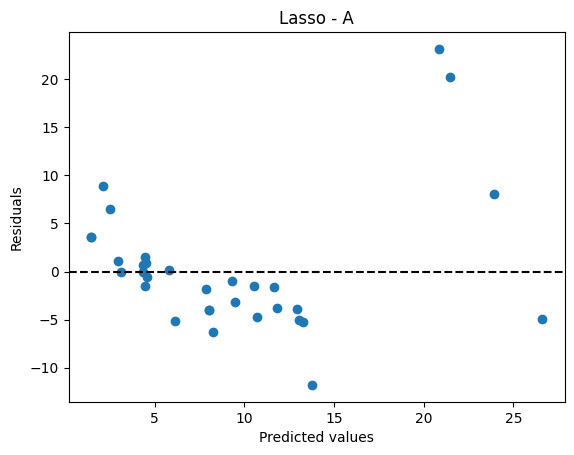

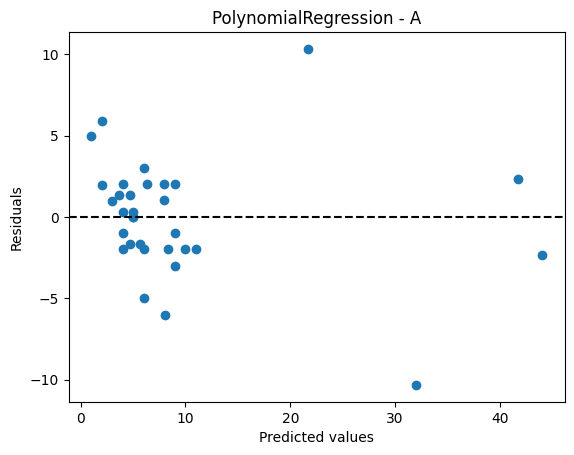

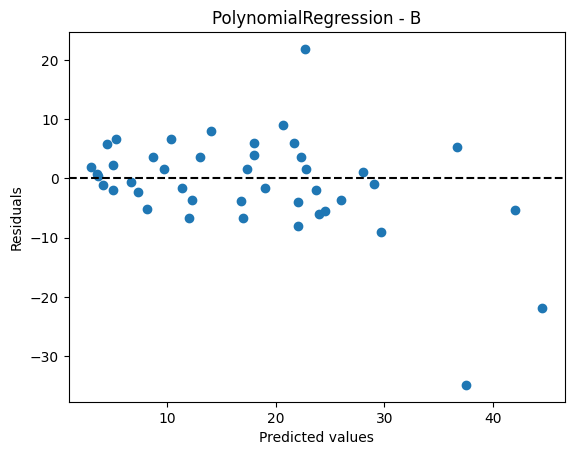

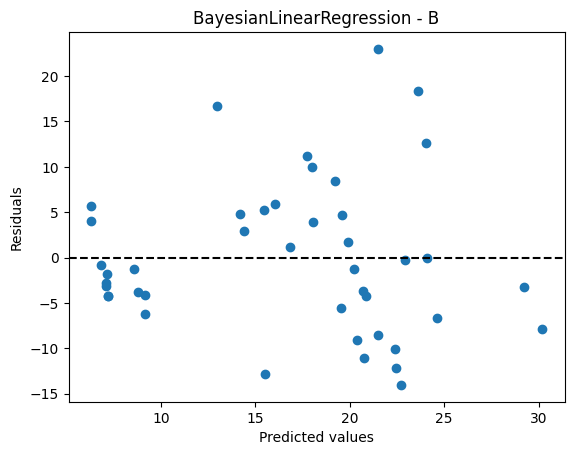

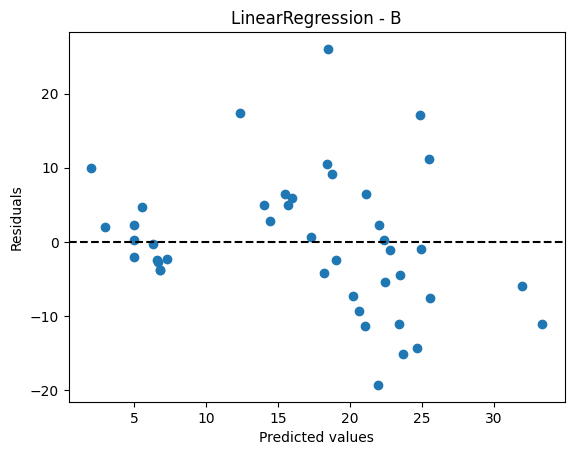

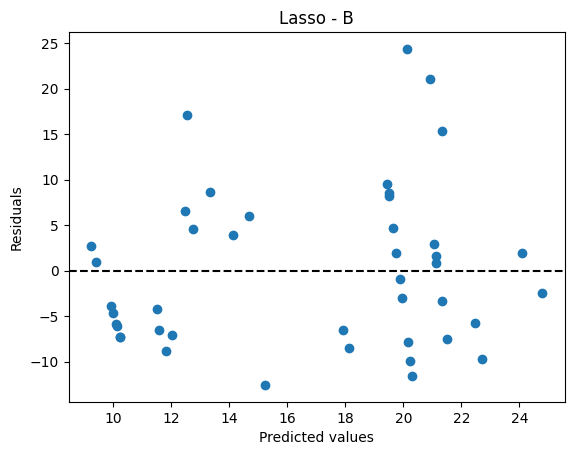

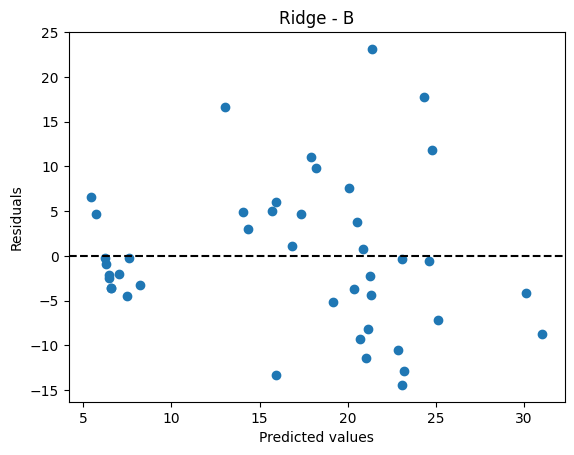

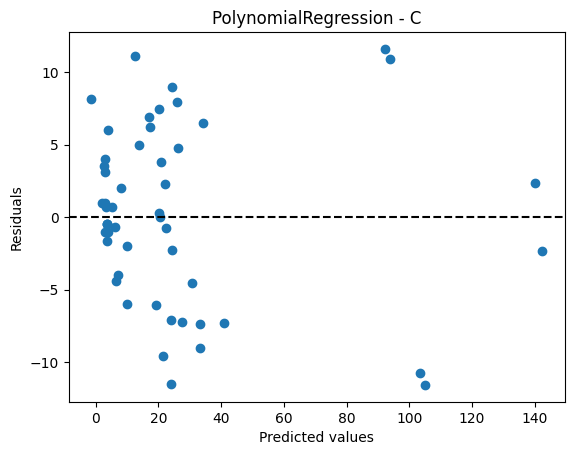

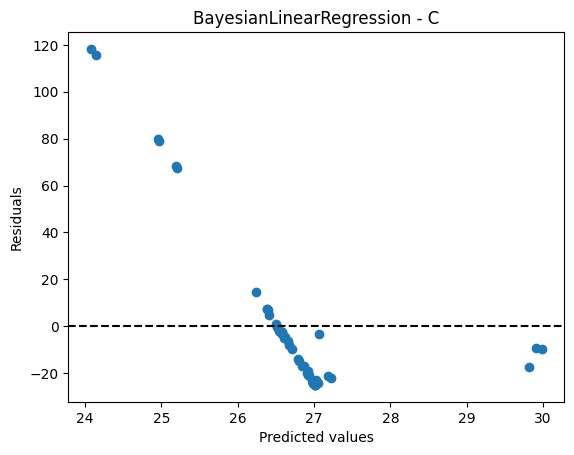

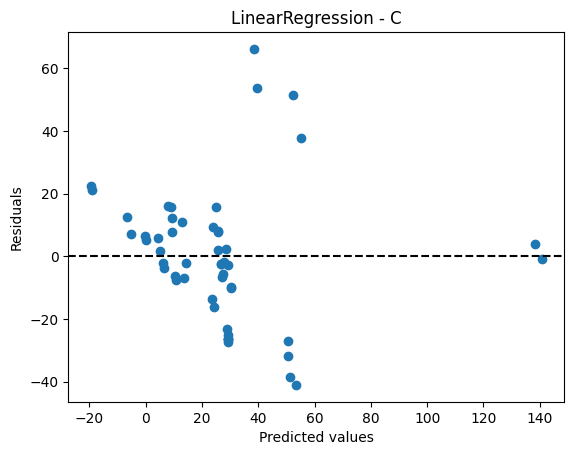

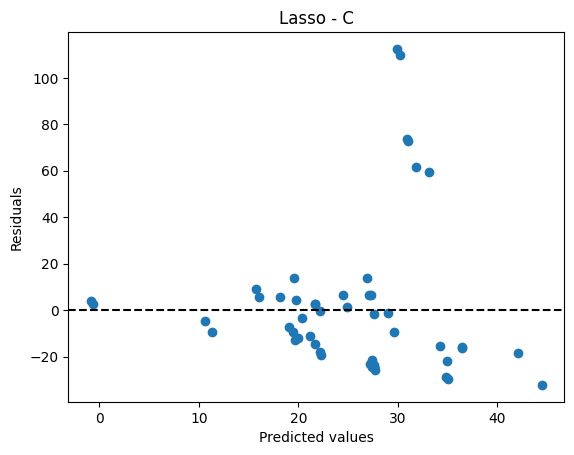

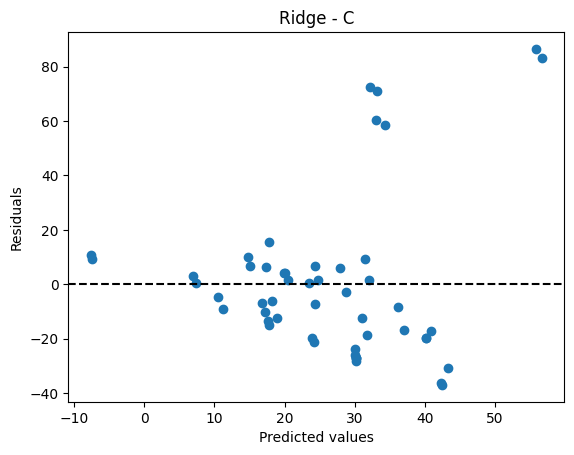

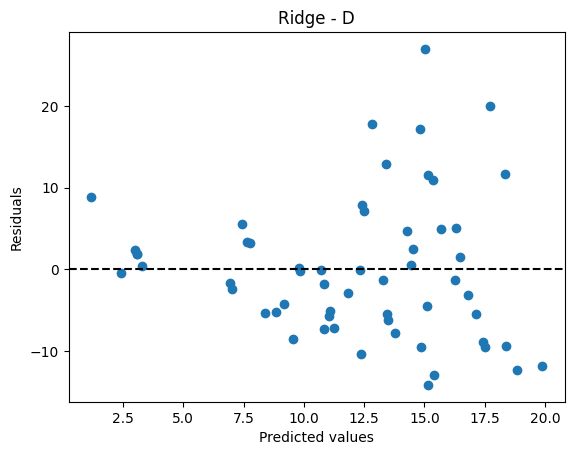

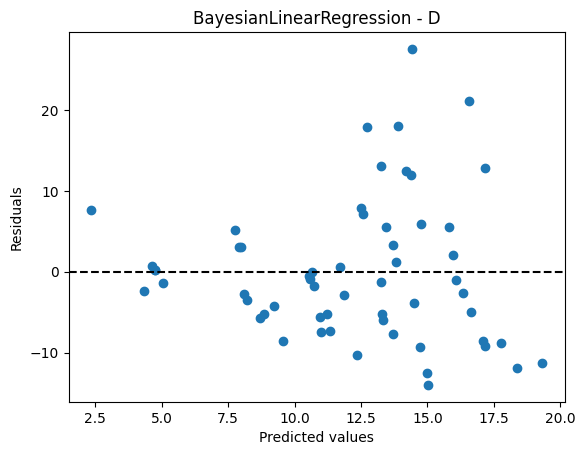

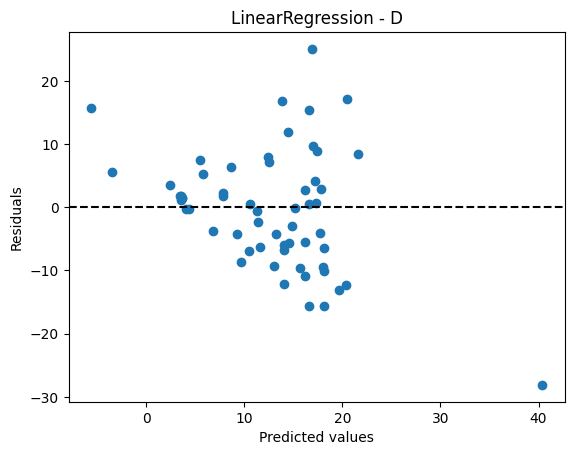

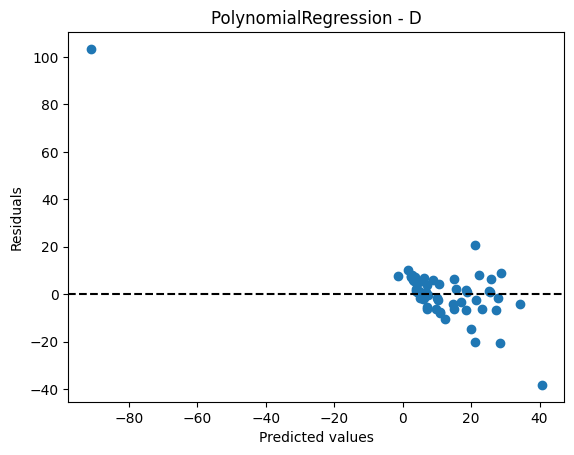

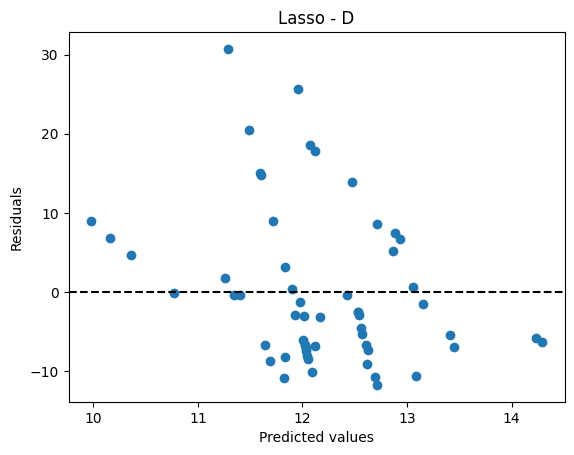

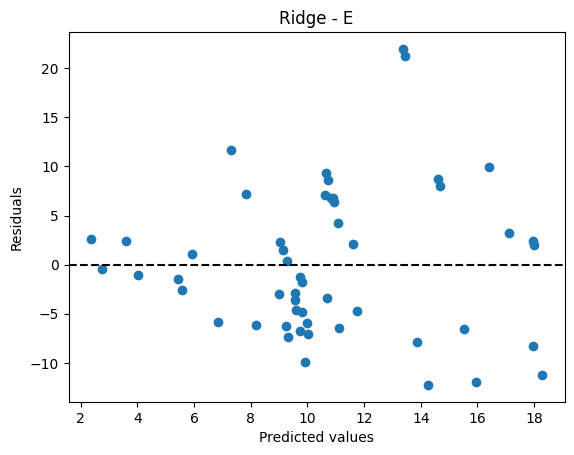

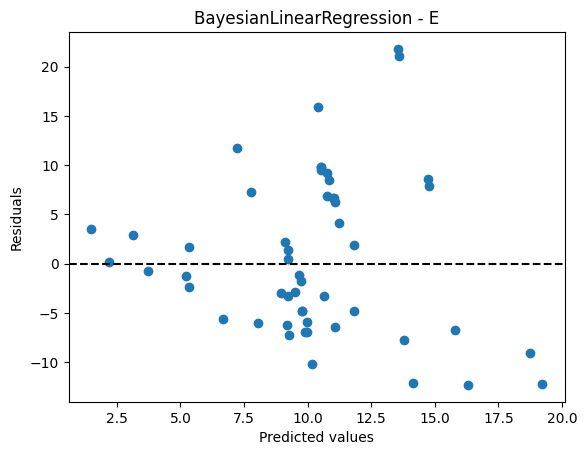

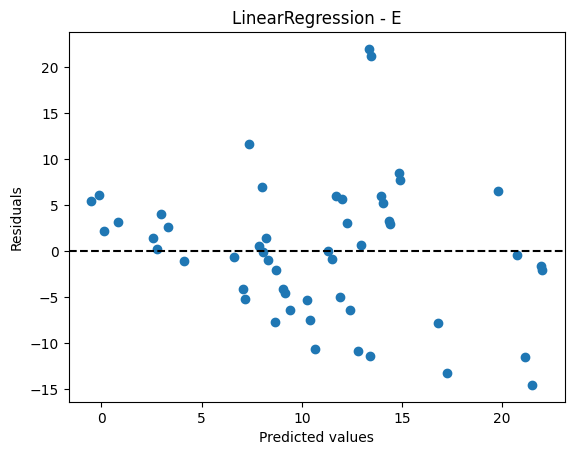

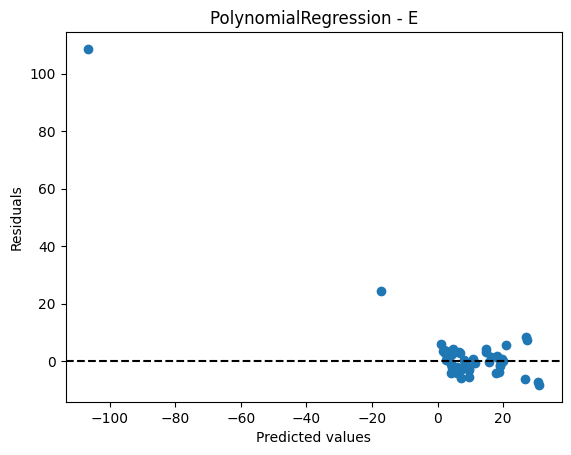

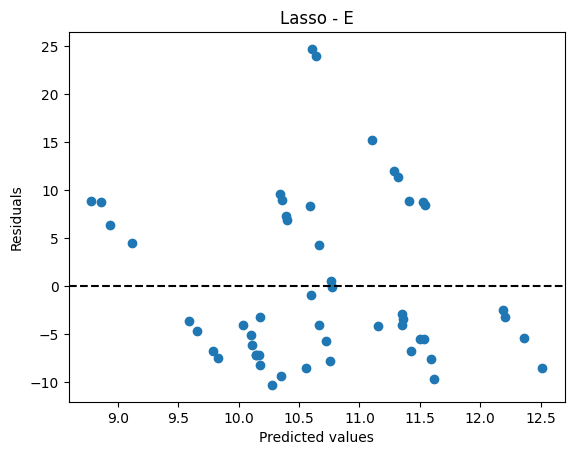

In [210]:
for site in df_results["Site"].unique():
    df_site = df_results[df_results["Site"] == site]
    for model in df_site["Model"].unique():
        df_model = df_site[df_site["Model"] == model]
        y_pred = df_model["y_pred"].values[0]
        residuals = df_model["Residuals"].values[0]
        plt.scatter(y_pred, residuals)
        plt.axhline(y=0.0, color="black", linestyle="--")
        plt.title(f"{model} - {site}")
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.show()

#### Predicted vs Actual

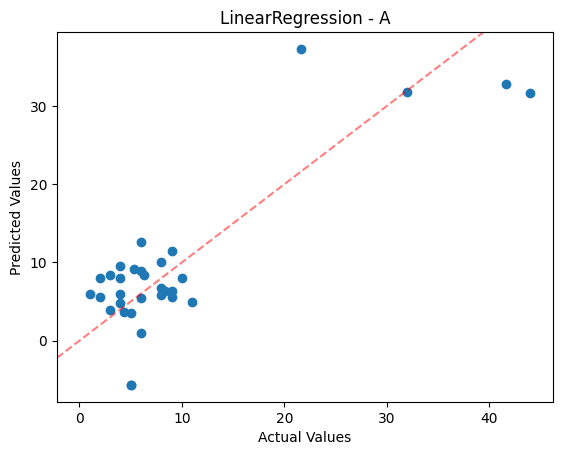

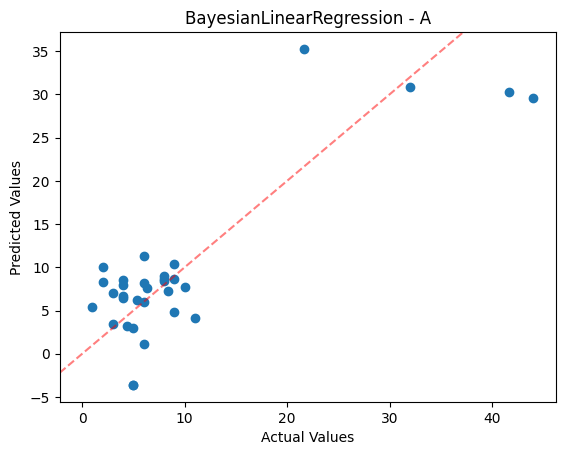

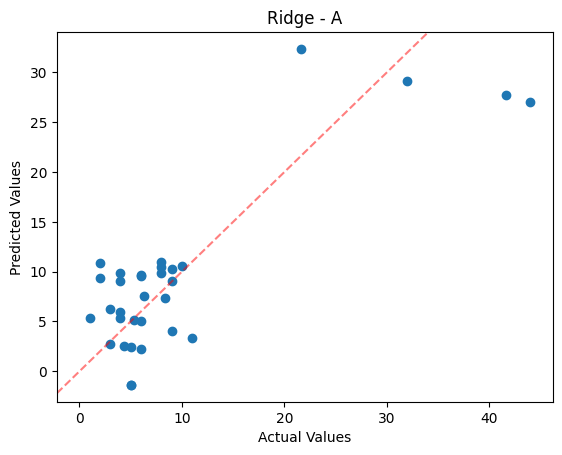

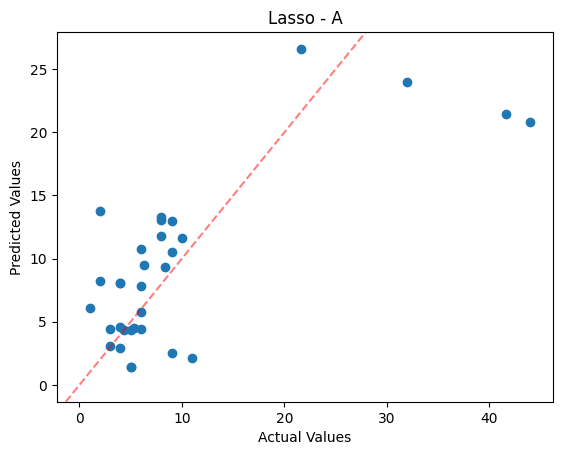

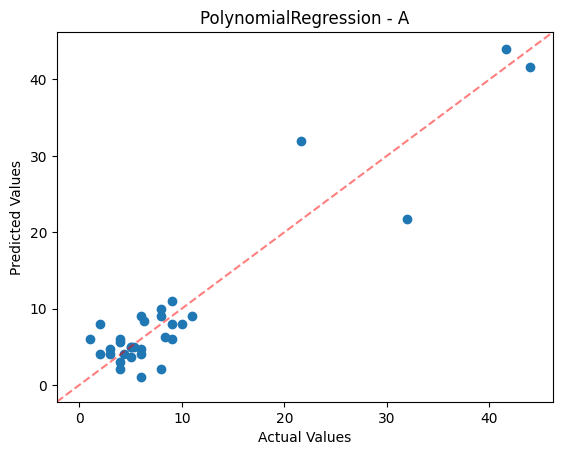

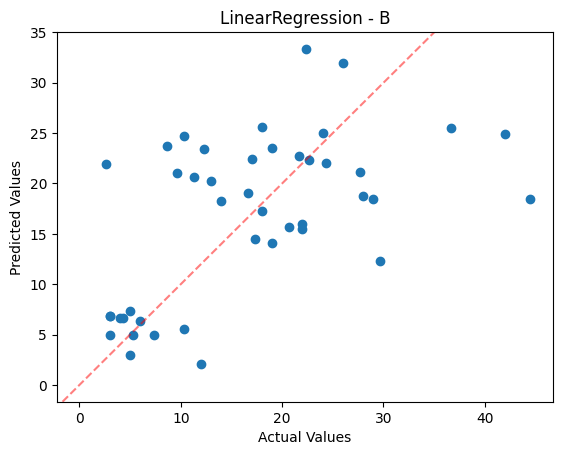

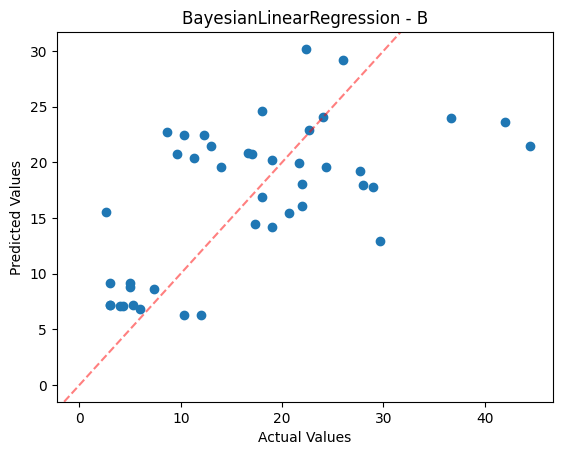

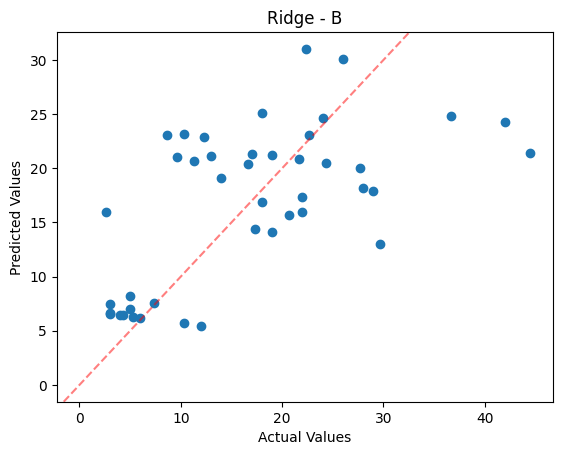

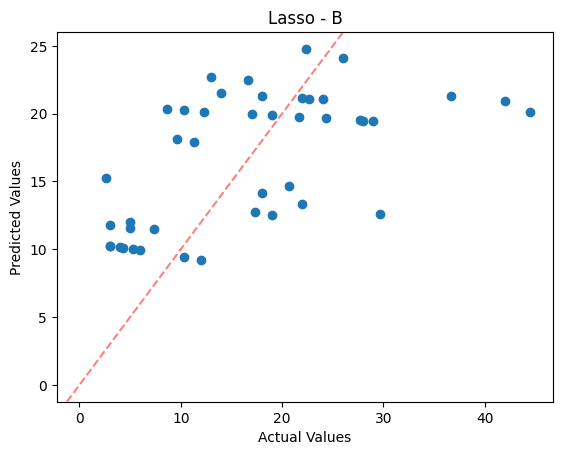

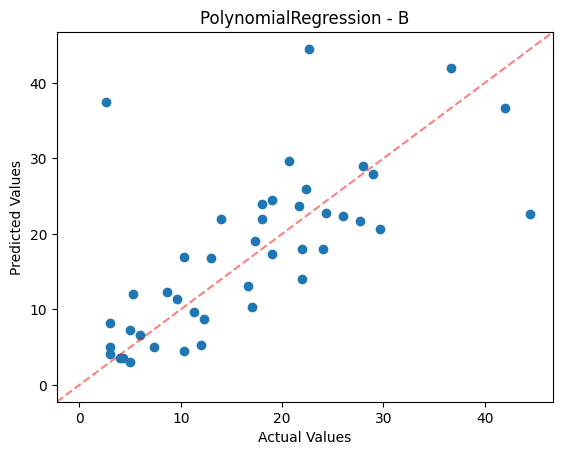

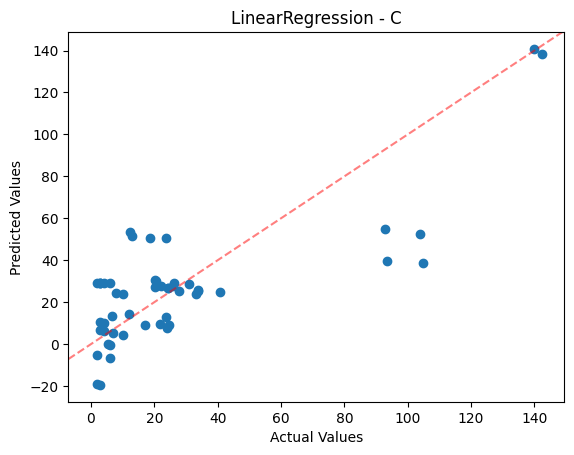

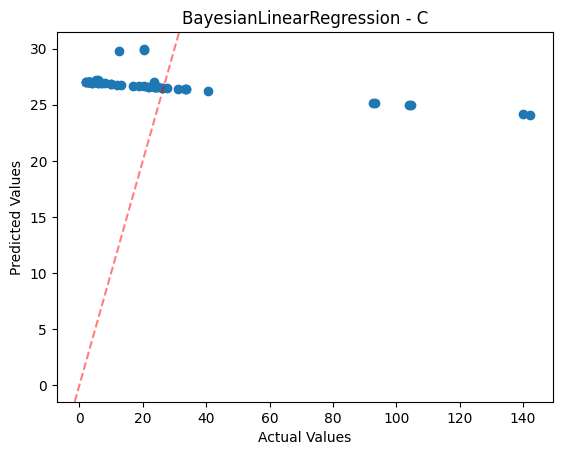

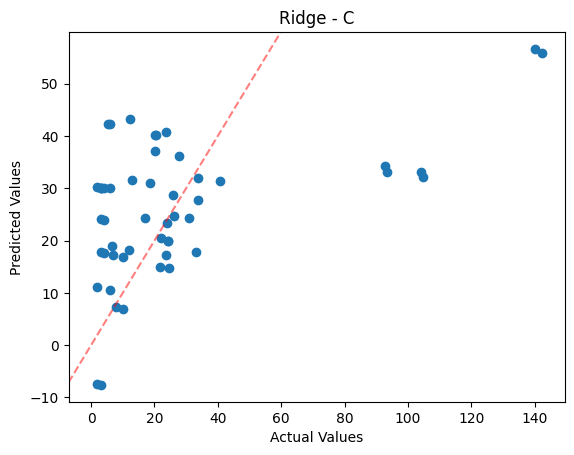

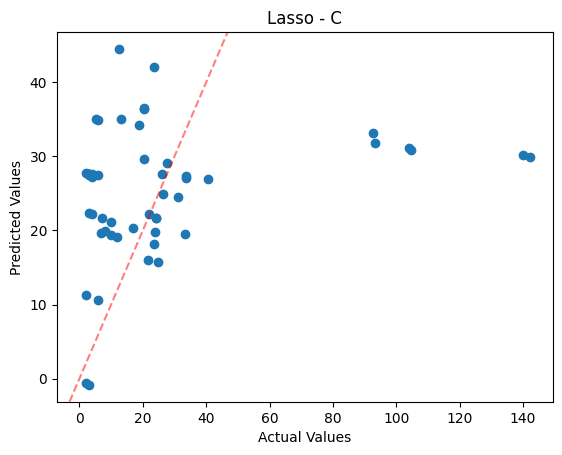

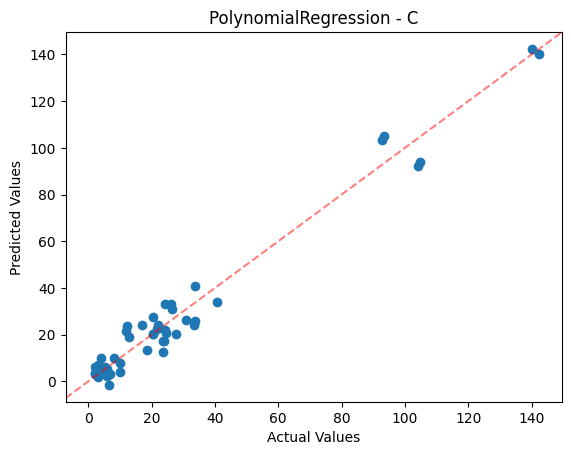

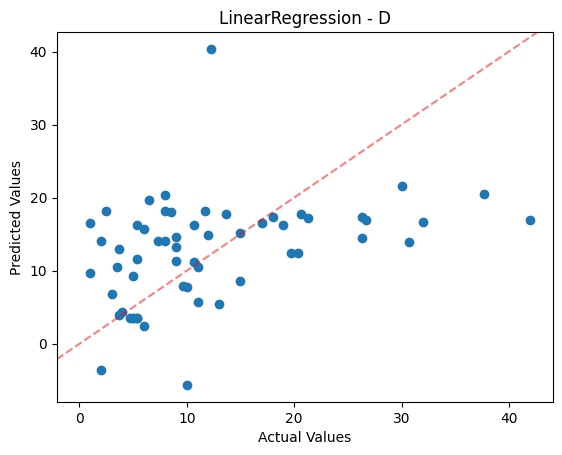

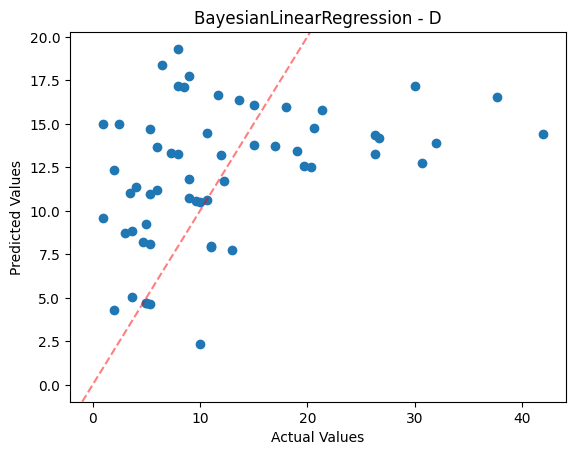

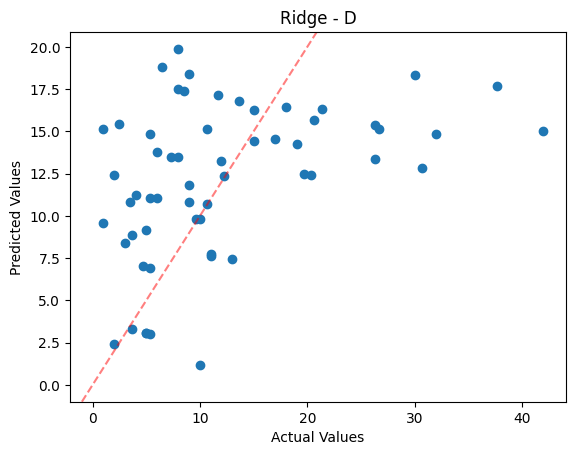

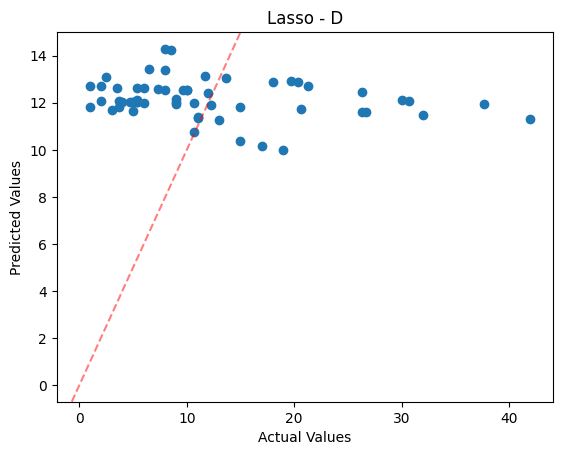

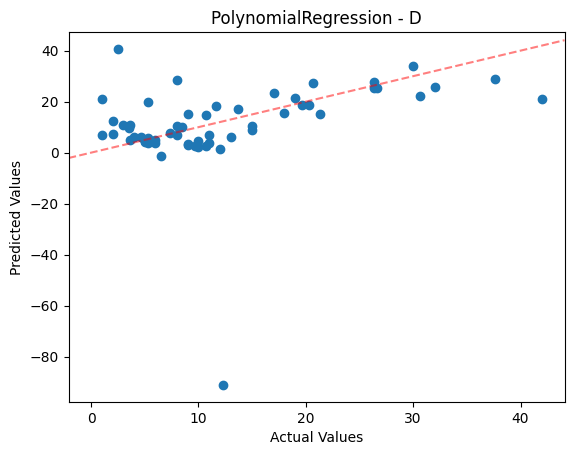

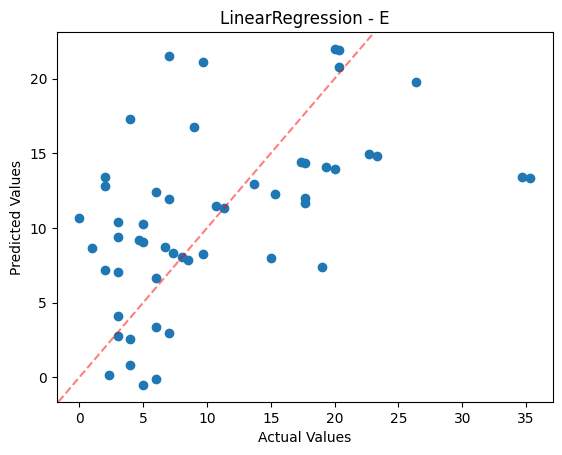

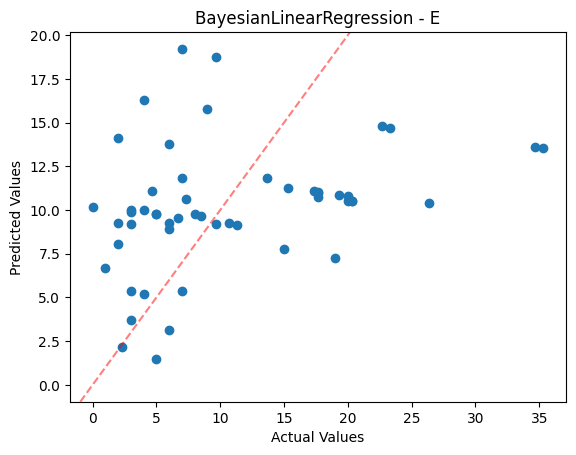

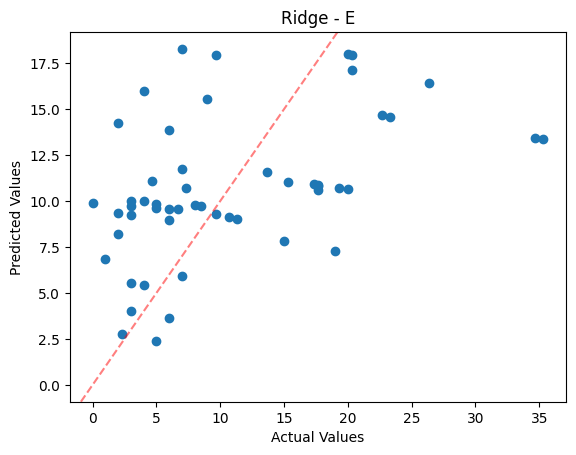

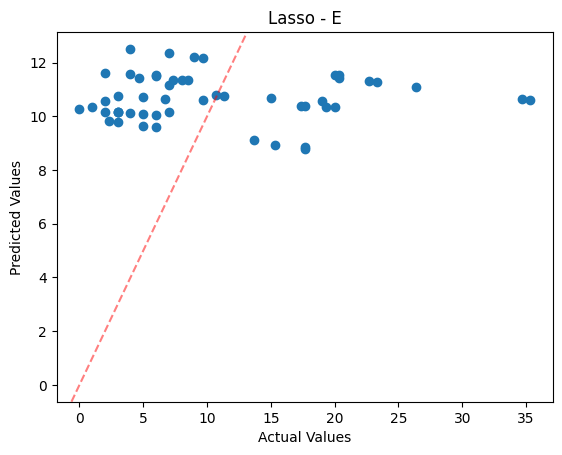

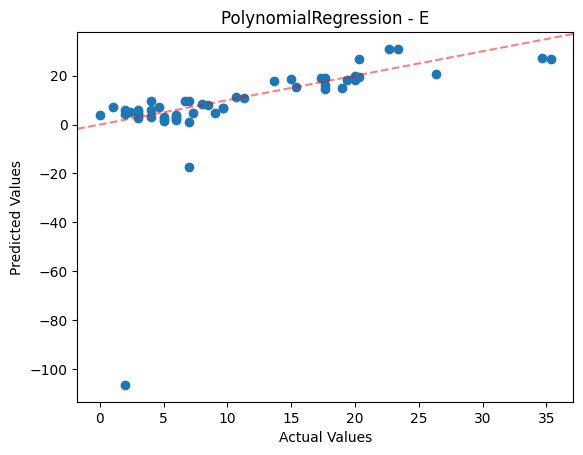

In [211]:
for site in df_results["Site"].unique():
    for model in df_results["Model"].unique():
        y_test = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_true"].values[0]
        y_pred = df_results[
            (df_results["Site"] == site) & (df_results["Model"] == model)
        ]["y_pred"].values[0]

        plt.scatter(y_test, y_pred)
        plt.axline([0, 0], [1, 1], color="red", linestyle="--", alpha=0.5)
        plt.title(f"{model} - {site}")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.show()